# IMPORT DEPENDENCIES

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, optimize
from scipy.stats import lognorm
from scipy.stats import beta
from math import log, pow
from functools import partial

import scipy.stats.mstats as mstats

import nltk

import sklearn
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import string

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import os
import glob

from collections import Counter
import collections

import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show_hist

import geopandas as gpd

import cartopy as cp
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import cartopy.io.img_tiles as cimgt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, FloatSlider, IntSlider
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Download data, set path, and read lithology logs from pickles

Datasets used in this notebook can be accessed and downloaded from:

https://drive.google.com/open?id=1SGr1m4FAWCCfv3M7aIDfMzmOKwygULzm

**Note: data_path should be the path where you downloaded the files under 'Modelling' from Google Drive**

In [2]:
data_path='/Users/JCastilla/Google Drive/CSIRO/Projects AU/PIWI/Modelling/'

In [3]:
all_Datums = pd.read_pickle(data_path + 'data_in/WIR/all_Datums.pkl')
all_Construction = pd.read_pickle(data_path + 'data_in/WIR/all_Construction.pkl')
all_Status = pd.read_pickle(data_path + 'data_in/WIR/all_Status.pkl')
all_LithologyLog = pd.read_pickle(data_path + 'data_in/WIR/all_LithologyLog.pkl')
all_SummaryLog = pd.read_pickle(data_path + 'data_in/WIR/all_SummaryLog.pkl')
all_SiteAquifers = pd.read_pickle(data_path + 'data_in/WIR/all_SiteAquifers.pkl')
all_SiteDetails = pd.read_pickle(data_path + 'data_in/WIR/all_SiteDetails.pkl')

In [4]:
all_SiteDetails.columns

Index([u'Site Type', u'Site Subtype', u'Site Geographic Feature',
       u'Site Spatial Type', u'Default Site Num Sys',
       u'Default Site Reference', u'Default Site Context Name',
       u'Default Site Name', u'Other Site References', u'Other Site Names',
       u'AWRC Reference', u'BOM Reference', u'MET Reference',
       u'WRC1 Free Text Reference', u'Zone', u'Easting', u'Northing',
       u'Longitude', u'Latitude', u'Geographic Datum',
       u'Geographic Precision (+/- metres)', u'Geographic Assessment Method',
       u'1:250,000 Map Index', u'GgStn Catchment Area (km2)', u'Asset Owner',
       u'Data Owner', u'Commence', u'Cease', u'Site Purpose Current',
       u'Site Purpose Historical', u'Projects', u'Aquifers (DOW)',
       u'Aquifers (as reported)', u'River Basin', u'Catchment', u'Estuary',
       u'BOM Rainfall District', u'Local Govt Authority', u'Locality',
       u'Department Region', u'Local Landmark Name', u'Groundwater Province',
       u'Groundwater Area', u'Groun

In [5]:
all_LithologyLog.columns

Index([u'Default Site  Reference', u'Logged By', u'Log Date',
       u'Log Date Reliability', u'Depth Reference Point', u'Interpreted By',
       u'Comment', u'Depth From Reliability', u'Depth From (m)',
       u'Depth To Reliability', u'Depth To (m)', u'Lithological Description'],
      dtype='object')

In [6]:
all_SummaryLog.columns

Index([u'Default Site Reference', u'Logged By', u'Log Date',
       u'Log Date Reliability', u'Depth Reference Point', u'Interpreted By',
       u'Interpreted Date', u'Interpreted Date Reliability', u'Comment',
       u'Depth From Reliability ', u'Depth From (m)', u'Depth To Reliability',
       u'Depth To (m)', u'Stratigraphy', u'Lithology 1', u'Lithology 2',
       u'Lithology 3'],
      dtype='object')

In [7]:
df=all_LithologyLog

# Exploratory analysis of the lithology logs

## Reset index and display dataframe

In [8]:
df = df.reset_index()
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
1            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
27           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

## Remove punctuation

In [9]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [10]:
df['Lithological Description'] = df['Lithological Description'].apply(remove_punctuations)

In [11]:
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
1            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
27           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

## Change all to lowercase

In [12]:
df['Lithological Description'] = df['Lithological Description'].str.lower()

In [13]:
df.head()

WIN Site ID  Default Site  Reference             Logged By    Log Date  \
0         3020                 61410058  Authority Not Known   30/06/1975   
1         3020                 61410058  Authority Not Known   30/06/1975   
2         3020                 61410058  Authority Not Known   30/06/1975   
3         3020                 61410058  Authority Not Known   30/06/1975   
4         3020                 61410058  Authority Not Known   30/06/1975   

  Log Date Reliability Depth Reference Point  \
0           Known year          Ground level   
1           Known year          Ground level   
2           Known year          Ground level   
3           Known year          Ground level   
4           Known year          Ground level   

                     Interpreted By Comment Depth From Reliability  \
0  Non geologist - Unknown Org Type    None                      =   
1  Non geologist - Unknown Org Type    None                      =   
2  Non geologist - Unknown Org Type    None                      =   
3  Non geologist - Unknown Org Type    None                      =   
4  Non geologist - Unknown Org Type    None                      =   

   Depth From (m) Depth To Reliability  Depth To (m)  \
0             0.0                    =           0.3   
1             0.3                    =           0.4   
2             0.4                    =           2.0   
3             2.0                    =           6.0   
4             6.0                    =           9.0   

                            Lithological Description  
0                                       surface sand  
1  sand yellow brown ferruginized bhorizon or thi...  
2  sand yellow brown slightly clayey finemedium m...  
3  sand light grey fine medium modwell sorted qtz...  
4  sand light grey medvery coarse tending to be b...

## Count most common word frequencies

In [14]:
n_most_common=1000

list_most_common=Counter(" ".join(df["Lithological Description"]).split()).most_common(n_most_common)
df_most_common=pd.DataFrame(list_most_common, columns=["word","frequency"])

df_most_common.to_csv(data_path + 'lithology_analysis/'+'PIWI_'+str(n_most_common)+'_most_common_words.csv', index=False)

df_most_common

word  frequency
0                sand       3492
1                clay       1909
2                 and       1666
3                  to       1557
4                grey       1533
5                fine       1169
6              coarse       1020
7               brown       1009
8               sandy        775
9              yellow        746
10             medium        731
11               with        706
12            grained        660
13             sorted        637
14            rounded        636
15              white        603
16          limestone        600
17              light        584
18             grains        570
19               very        524
20               dark        511
21                 of        486
22             quartz        485
23              shale        475
24               well        447
25               hard        396
26              black        383
27                qtz        360
28          sandstone        348
29             clayey        344
..                ...        ...
970  semiconsolidated          2
971            5560ft          2
972          finefine          2
973      calcareously          2
974             monor          2
975            powder          2
976            packed          2
977          jurassic          2
978          100140ft          2
979         clayified          2
980        browngreen          2
981       creamyellow          2
982             parts          2
983             coffe          2
984               off          2
985            banded          2
986              cave          2
987              lake          2
988         yellowred          2
989             tests          2
990               esp          2
991            pepper          2
992             drift          2
993          sandrock          2
994    biocalcarenite          2
995             buffy          2
996               8ft          2
997                46          2
998                44          2
999                45          2

[1000 rows x 2 columns]

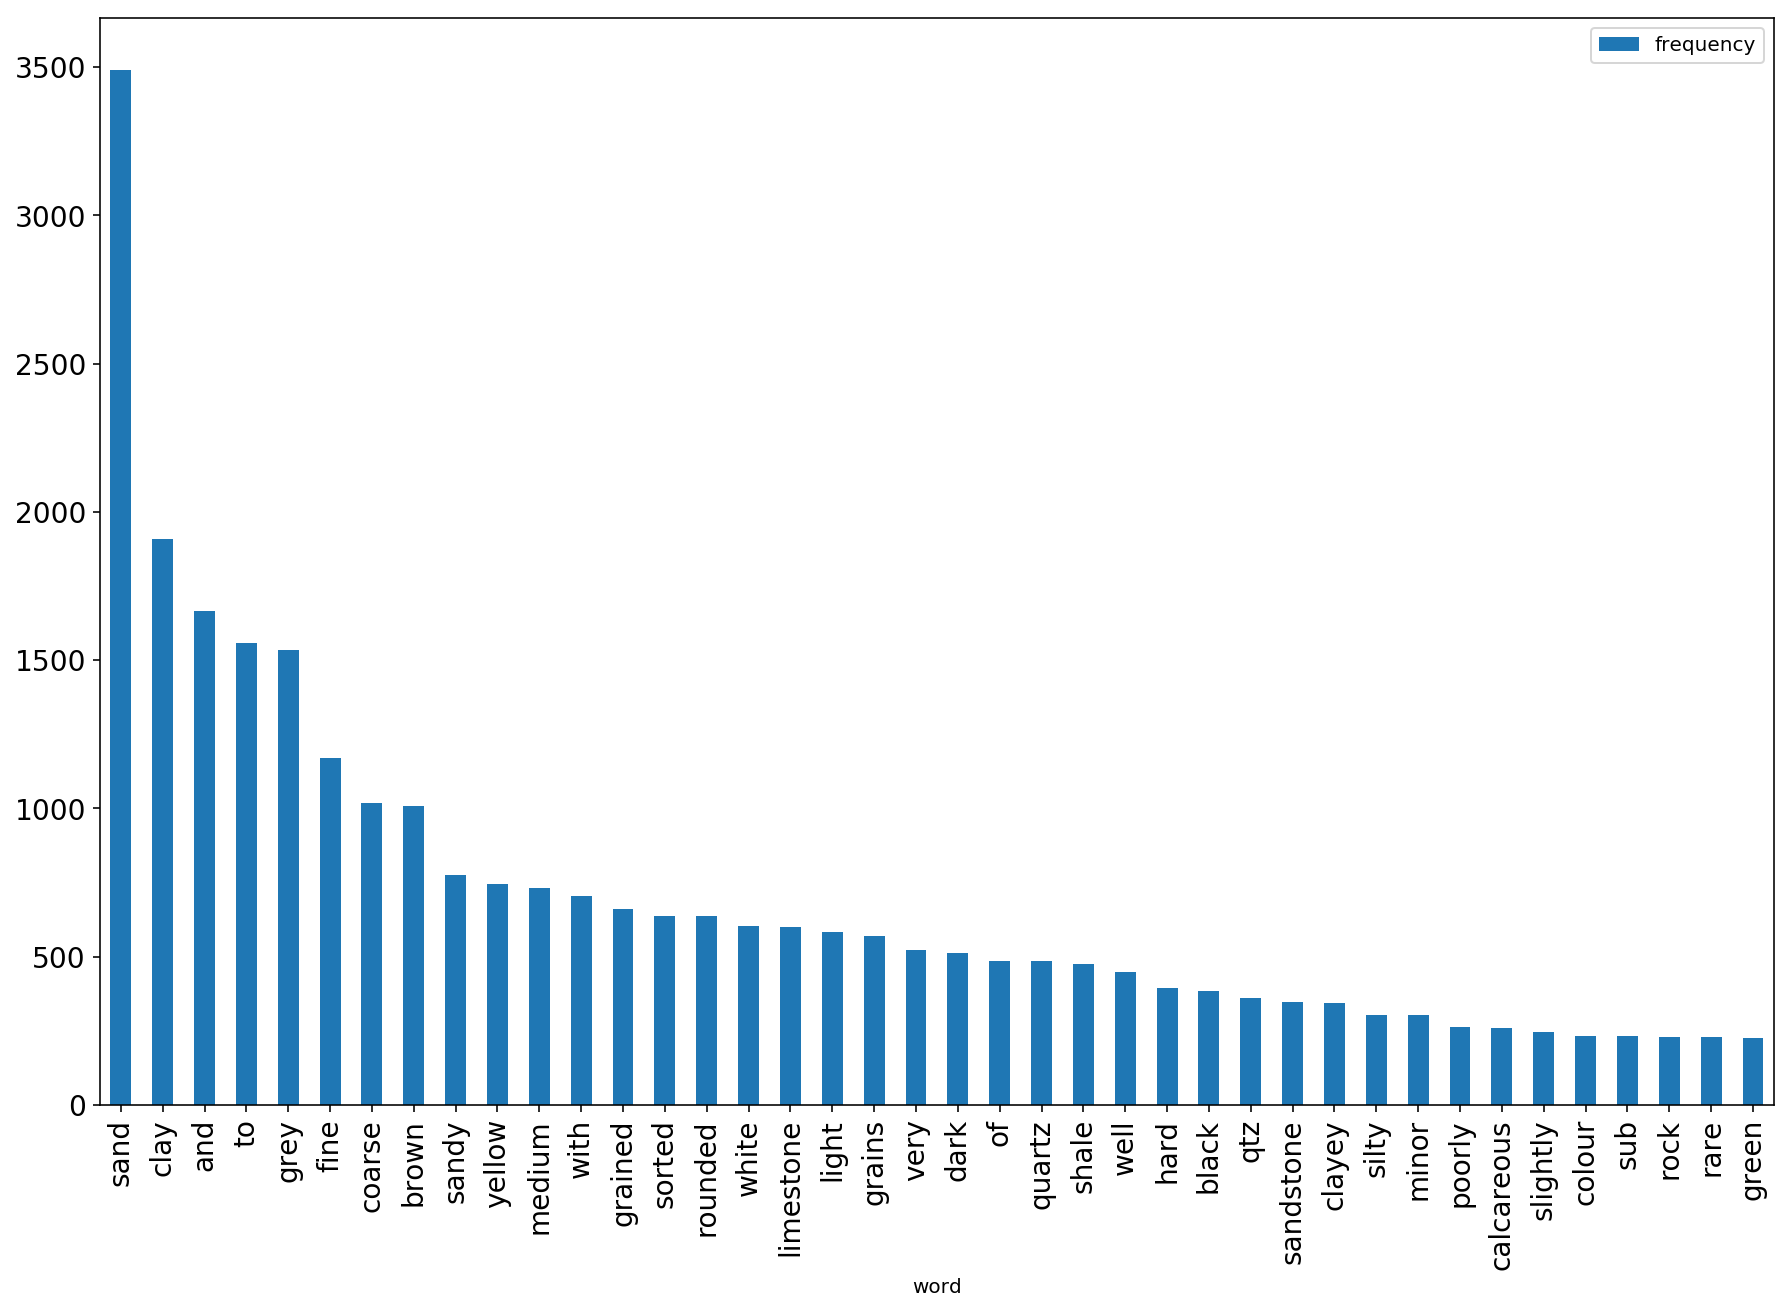

In [15]:
df_most_common.head(n=40).plot.bar(x='word', figsize=(15,10), fontsize=14)

## Extract primary and secondary lithologies

### add new columns to populate with primary and secondary lithologies

In [16]:
df["Lithology_1"]=""
df["Lithology_2"]=""

In [17]:
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
1            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
27           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

### Look for specific lithologies in logs and rank based on their position in the sentence

Results are stored in a numpy array "sentence_positions" (rows=records, columns=lithologies)

In [18]:
from matplotlib import colors

lithologies=['sand','sandstone','clay','limestone','shale','basalt','coffee']

#set an intuitive colormap for further plotting
lithology_cmap = colors.ListedColormap(['sandybrown','gold','chocolate','yellow','lightsteelblue','dimgray','darkgoldenrod'])
bounds = [0,0.9,1.9,2.9,3.9,4.9,5.9,6.9]
norm = colors.BoundaryNorm(bounds, lithology_cmap.N)

#enumerate lithologies sequentially
lithologies_num=np.arange(0,len(lithologies),1)
number_of_lithologies=len(lithologies)
number_of_records=df.shape[0]

sentence_positions=np.empty([number_of_records,number_of_lithologies])

lithology_index=0

for lithology in lithologies:
    
    record_index=0

    for index, row in df.iterrows():
    
        sentence = row['Lithological Description']
        words = sentence.split(' ')
        
        if lithology in words:
            pos = words.index(lithology)
        else:
            pos=-1
            
        sentence_positions[record_index,lithology_index]=pos
        
        record_index += 1
    
    lithology_index +=1

### This code doesn't need to be run, just for testing the extraction of main lithologies

In [19]:
sentence_positions[sentence_positions == -1] = 'nan'

In [20]:
sentence_positions[11]

array([  0.,  nan,  nan,  nan,  nan,  nan,   1.])

In [21]:
0 in sentence_positions[11]

True

In [22]:
all(np.isnan(i) for i in sentence_positions[11])

False

In [23]:
ranks = mstats.rankdata(np.ma.masked_invalid(sentence_positions[11]))
print(ranks)

[ 1.  0.  0.  0.  0.  0.  2.]


In [24]:
ranks[ranks == 0] = np.nan
ranks -= 1

In [25]:
ranks

array([  0.,  nan,  nan,  nan,  nan,  nan,   1.])

In [26]:
lithologies[np.where(ranks==1)[0][0]]

'coffee'

In [27]:
any(ranks==1)

True

### For each record, identify lithologies ranked in positions 1 & 2 and store in a new dataframe column

In [28]:
record_index=0

for index, row in df.iterrows():
    
    if all(np.isnan(i) for i in sentence_positions[record_index]):
        
        df.set_value(record_index,'Lithology_1','')
        df.set_value(record_index,'Lithology_2','')
        df.set_value(record_index,'Lithology_1_num',np.nan)
        df.set_value(record_index,'Lithology_2_num',np.nan)
 
    else:
    
        ranks = mstats.rankdata(np.ma.masked_invalid(sentence_positions[record_index]))
        ranks[ranks == 0] = np.nan
        ranks -= 1
        
        df.set_value(record_index,'Lithology_1',lithologies[np.where(ranks==0)[0][0]])
        df.set_value(record_index,'Lithology_1_num',lithologies_num[np.where(ranks==0)[0][0]])
        
        if any(ranks==1):
            df.set_value(record_index,'Lithology_2',lithologies[np.where(ranks==1)[0][0]])
            df.set_value(record_index,'Lithology_2_num',lithologies_num[np.where(ranks==1)[0][0]])
            
        else:
            df.set_value(record_index,'Lithology_2','')
            df.set_value(record_index,'Lithology_2_num',np.nan)
 
    record_index += 1

/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: set_v

In [29]:
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
1            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
27           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

### Round up 'depth to' and 'depth from' columns

In [30]:
df['Depth From (m)']=df['Depth From (m)'].apply(np.ceil)
df['Depth To (m)']=df['Depth To (m)'].apply(np.ceil)

In [31]:
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
1            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
27           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

### Drop rows where the description interval is zero

In [32]:
df = df.drop(df[df['Depth From (m)'] == df['Depth To (m)']].index)

In [33]:
df

WIN Site ID  Default Site  Reference                       Logged By  \
0            3020                 61410058            Authority Not Known    
2            3020                 61410058            Authority Not Known    
3            3020                 61410058            Authority Not Known    
4            3020                 61410058            Authority Not Known    
5            3020                 61410058            Authority Not Known    
6            3032                 61410070            Authority Not Known    
7            3032                 61410070            Authority Not Known    
8            3032                 61410070            Authority Not Known    
9            3032                 61410070            Authority Not Known    
10           3041                 61410079            Authority Not Known    
11           3041                 61410079            Authority Not Known    
12           3041                 61410079            Authority Not Known    
13           3041                 61410079            Authority Not Known    
14           3067                 61410105            Authority Not Known    
15           3067                 61410105            Authority Not Known    
16           3067                 61410105            Authority Not Known    
17           3067                 61410105            Authority Not Known    
18           3067                 61410105            Authority Not Known    
19           3067                 61410105            Authority Not Known    
20           3067                 61410105            Authority Not Known    
21           3067                 61410105            Authority Not Known    
22           3074                 61410112            Authority Not Known    
23           3074                 61410112            Authority Not Known    
24           3074                 61410112            Authority Not Known    
25           3074                 61410112            Authority Not Known    
26           3074                 61410112            Authority Not Known    
28           3074                 61410112            Authority Not Known    
29           3074                 61410112            Authority Not Known    
30           3089                 61410127            Authority Not Known    
31           3089                 61410127            Authority Not Known    
...           ...                      ...                             ...   
6758     23018560                 61407105  Land And Water Quality Branch    
6759     23025664                 61411007              Montague Drilling    
6760     23025664                 61411007              Montague Drilling    
6761     23025664                 61411007              Montague Drilling    
6762     23025664                 61411007              Montague Drilling    
6763     23025664                 61411007              Montague Drilling    
6764     23025664                 61411007              Montague Drilling    
6765     23025664                 61411007              Montague Drilling    
6766     23025664                 61411007              Montague Drilling    
6767     23025664                 61411007              Montague Drilling    
6768     23025664                 61411007              Montague Drilling    
6769     23025664                 61411007              Montague Drilling    
6770     23025664                 61411007              Montague Drilling    
6771     23025664                 61411007              Montague Drilling    
6772     23025664                 61411007              Montague Drilling    
6773     23025664                 61411007              Montague Drilling    
6774     23025664                 61411007              Montague Drilling    
6775     23025664                 61411007              Montague Drilling    
6776     23025664                 61411007              Montague Drilling    
6777     23025664           

### Reset index to 'WIN site ID'

In [34]:
df.set_index('WIN Site ID',inplace=True)

In [35]:
df

Default Site  Reference                       Logged By  \
WIN Site ID                                                            
3020                        61410058            Authority Not Known    
3020                        61410058            Authority Not Known    
3020                        61410058            Authority Not Known    
3020                        61410058            Authority Not Known    
3020                        61410058            Authority Not Known    
3032                        61410070            Authority Not Known    
3032                        61410070            Authority Not Known    
3032                        61410070            Authority Not Known    
3032                        61410070            Authority Not Known    
3041                        61410079            Authority Not Known    
3041                        61410079            Authority Not Known    
3041                        61410079            Authority Not Known    
3041                        61410079            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3067                        61410105            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3074                        61410112            Authority Not Known    
3089                        61410127            Authority Not Known    
3089                        61410127            Authority Not Known    
...                              ...                             ...   
23018560                    61407105  Land And Water Quality Branch    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Montague Drilling    
23025664                    61411007              Mon

### Join with dataframe that has Easting and Northing data

In [36]:
df=df.join(all_SiteDetails[['Easting', 'Northing']], how='inner')

In [37]:
df

Default Site  Reference  \
WIN Site ID                            
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2988                        61410026   
2988                        61410026   
2988                        61410026   
2988                        61410026   
...                              ...   
23087068                    61470062   
23087068                    61470062   
23087102                    61470077   
23087102                    61470077   
23087102                    61470077   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087142                    61470065   
23087142                    61470065   
23087146                    61470066   
23087146                    61470066   
23087146                    61470066   
23087147                    61470067   
23087147                    61470067   
23087147                    61470067   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087289                    61470083   
23087289                    61470083   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   

                                            Logged By    Log Date  \
WIN Site ID                                                         
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                       

### Plot histograms of log intervals

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123582790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126db0fd0>]], dtype=object)

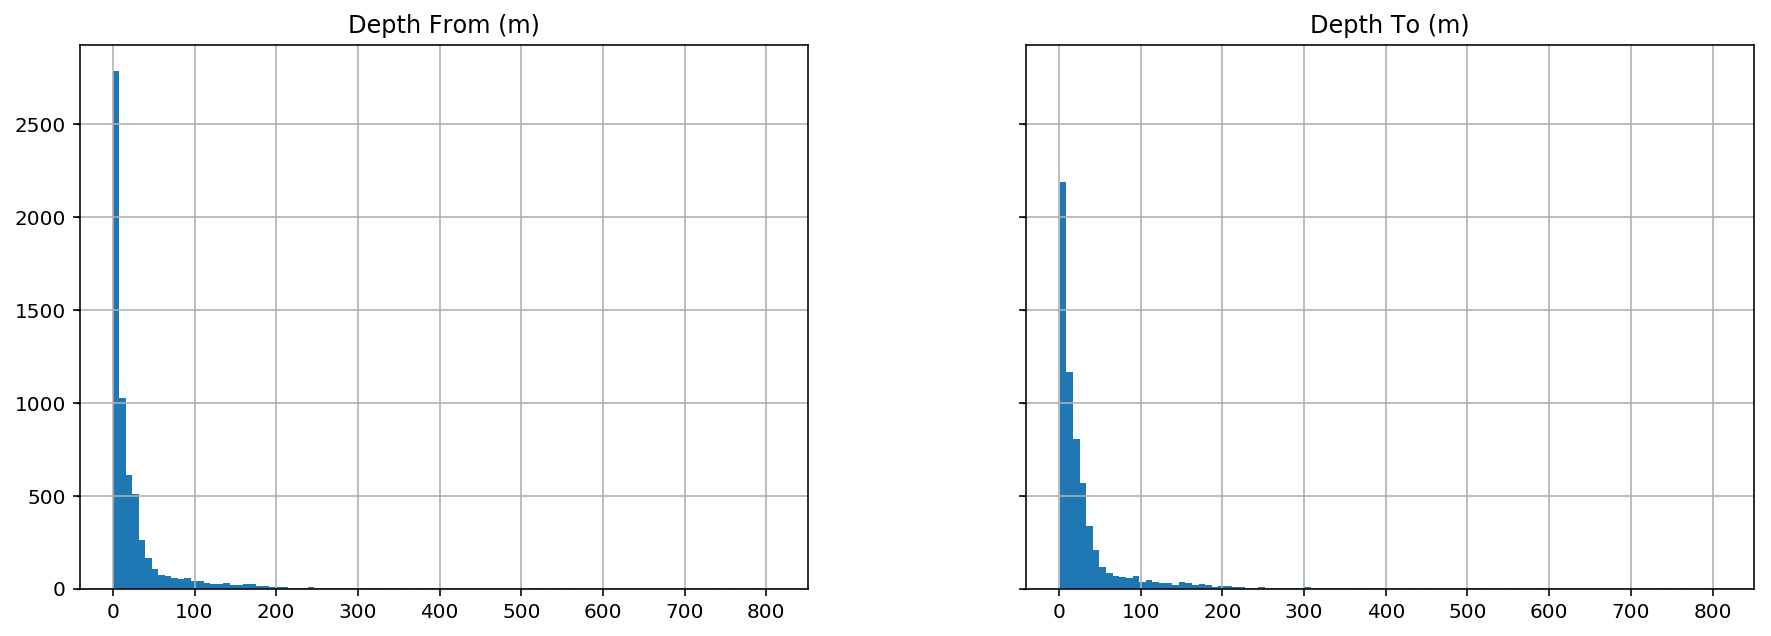

In [38]:
n_bins=100

df.hist(column=['Depth From (m)','Depth To (m)'], sharex=True, sharey=True, bins=n_bins, figsize=(15,5))

### Select logs that intersect a specific slicing depth

In [39]:
depth=5.

df.loc[(df['Depth From (m)'] <= depth) & (df['Depth To (m)'] >= depth)]

Default Site  Reference  \
WIN Site ID                            
2980                        61410018   
2982                        61410020   
2983                        61410021   
2984                        61410022   
2988                        61410026   
2989                        61410027   
2991                        61410029   
2993                        61410031   
2994                        61410032   
3009                        61410047   
3011                        61410049   
3020                        61410058   
3021                        61410059   
3022                        61410060   
3022                        61410060   
3023                        61410061   
3024                        61410062   
3025                        61410063   
3026                        61410064   
3027                        61410065   
3032                        61410070   
3033                        61410071   
3035                        61410073   
3036                        61410074   
3041                        61410079   
3041                        61410079   
3042                        61410080   
3043                        61410081   
3050                        61410088   
3050                        61410088   
...                              ...   
23019184                    61408009   
23019186                    61408011   
23019186                    61408011   
23019187                    61408012   
23019187                    61408012   
23019197                    61408006   
23019197                    61408006   
23025664                    61411007   
23025664                    61411007   
23030442                    61410655   
23030442                    61410655   
23042161                    61407114   
23042166                    61407115   
23042166                    61407115   
23086802                    61470051   
23086802                    61470051   
23087042                    61470053   
23087049                    61470056   
23087051                    61470058   
23087057                    61470061   
23087068                    61470062   
23087102                    61470077   
23087102                    61470077   
23087123                    61470079   
23087142                    61470065   
23087146                    61470066   
23087147                    61470067   
23087202                    61470068   
23087289                    61470083   
23087521                    61470084   

                                                     Logged By    Log Date  \
WIN Site ID                                                                  
2980                                      Authority Not Known   01/01/1900   
2982                                                 Allen A D  20/06/1975   
2983                                                 Allen A D  20/06/1975   
2984                                                 Allen A D  11/02/1977   
2988                                      Authority Not Known   30/06/1975   
2989                                      Authority Not Known   30/06/1975   
2991                                      Authority Not Known   30/06/1975   
2993                                                 Allen A D  13/06/1975   
2994                                                 Allen A D  13/06/1975   
3009                                      Authority Not Known   30/06/1975   
3011                                      Authority Not Known   30/06/1975   
3020                                      Authority Not Known   30/06/1975   
3021                                      Authority Not Known   30/06/1975   
3022                                      Authority Not Known   30/06/1975   
3022                                      Authority Not Known   30/06/1975   
3023                                                 Allen A D  25/06/1975   
3024                                                 Allen A D  25/06/1975   
3025      

# Facies KNN classifier (uses Scikit-Learn)

## Plot bore log locations

### Define extents for Cartopy plots

In [40]:
extent = [116, 115.75, -32.64, -32.29]

tile = cimgt.OSM()

data_proj=ccrs.epsg(28350)

near_field_extents=[379000, 411000, 6390000, 6423000]

### Function to plot bore log locations (slice by depth)

In [42]:
def plot_lithologydata_slice_points(slice_depth):

    df_slice=df.loc[(df['Depth From (m)'] <= slice_depth) & (df['Depth To (m)'] >= slice_depth)]

    fig,ax=plt.subplots(1,1,figsize=(15,15), subplot_kw={'projection': ccrs.epsg(28350),'extent': extent})

    stamen_terrain = cimgt.StamenTerrain()
    ax.add_image(stamen_terrain, 11)
        
    ax.add_geometries(Reader(data_path + 'Cartopy/GWSA').geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='k',zorder=1)
    ax.add_geometries(Reader(data_path + 'Cartopy/PFZ_Boundary_DraftReport_ll').geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='r',zorder=1)

    ax.scatter(df_slice.Easting.values,df_slice.Northing.values)

    for val,label in zip(ax.get_xticks(), ax.get_xticklabels()):
        label.set_text(str(val))
        label.set_position((val,0))  

    for val,label in zip(ax.get_yticks(), ax.get_yticklabels()):   
        label.set_text(str(val))
        label.set_position((0,val))  

    plt.tick_params(bottom=True,top=True,left=True,right=True,labelbottom=True,labeltop=False,labelleft=True,labelright=False)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)

    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')

    ax.grid(False)

    ax.text(0.1, 0.9, u'\u25B2 \nN ',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=25, 
    color='k',
    family='Arial',
    transform=ax.transAxes)
        
    ax.set_extent(near_field_extents, crs=data_proj)
    
    plt.title('bore log locations at %s m depth'%(slice_depth), fontsize=20, weight='bold')
    
interact_manual(plot_lithologydata_slice_points,slice_depth=FloatSlider(min=0, max=100, step=1));


interactive(children=(FloatSlider(value=0.0, description=u'slice_depth', step=1.0), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Import DEM and convert log depths to AHD

In [43]:
dem = rasterio.open(data_path + 'data_in/Rasters/piwi_lm_dem/hdr.adf')

In [44]:
dem.crs, dem.bounds, dem.transform

/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


(CRS({u'zone': 50, u'ellps': u'GRS80', u'no_defs': True, u'proj': u'utm', u'units': u'm', u'south': True}),
 BoundingBox(left=376109.9999999962, bottom=6389320.000000444, right=414609.99999999616, top=6429900.000000444),
 [376109.9999999962, 9.999999999999984, 0.0, 6429900.000000444, 0.0, -10.0])

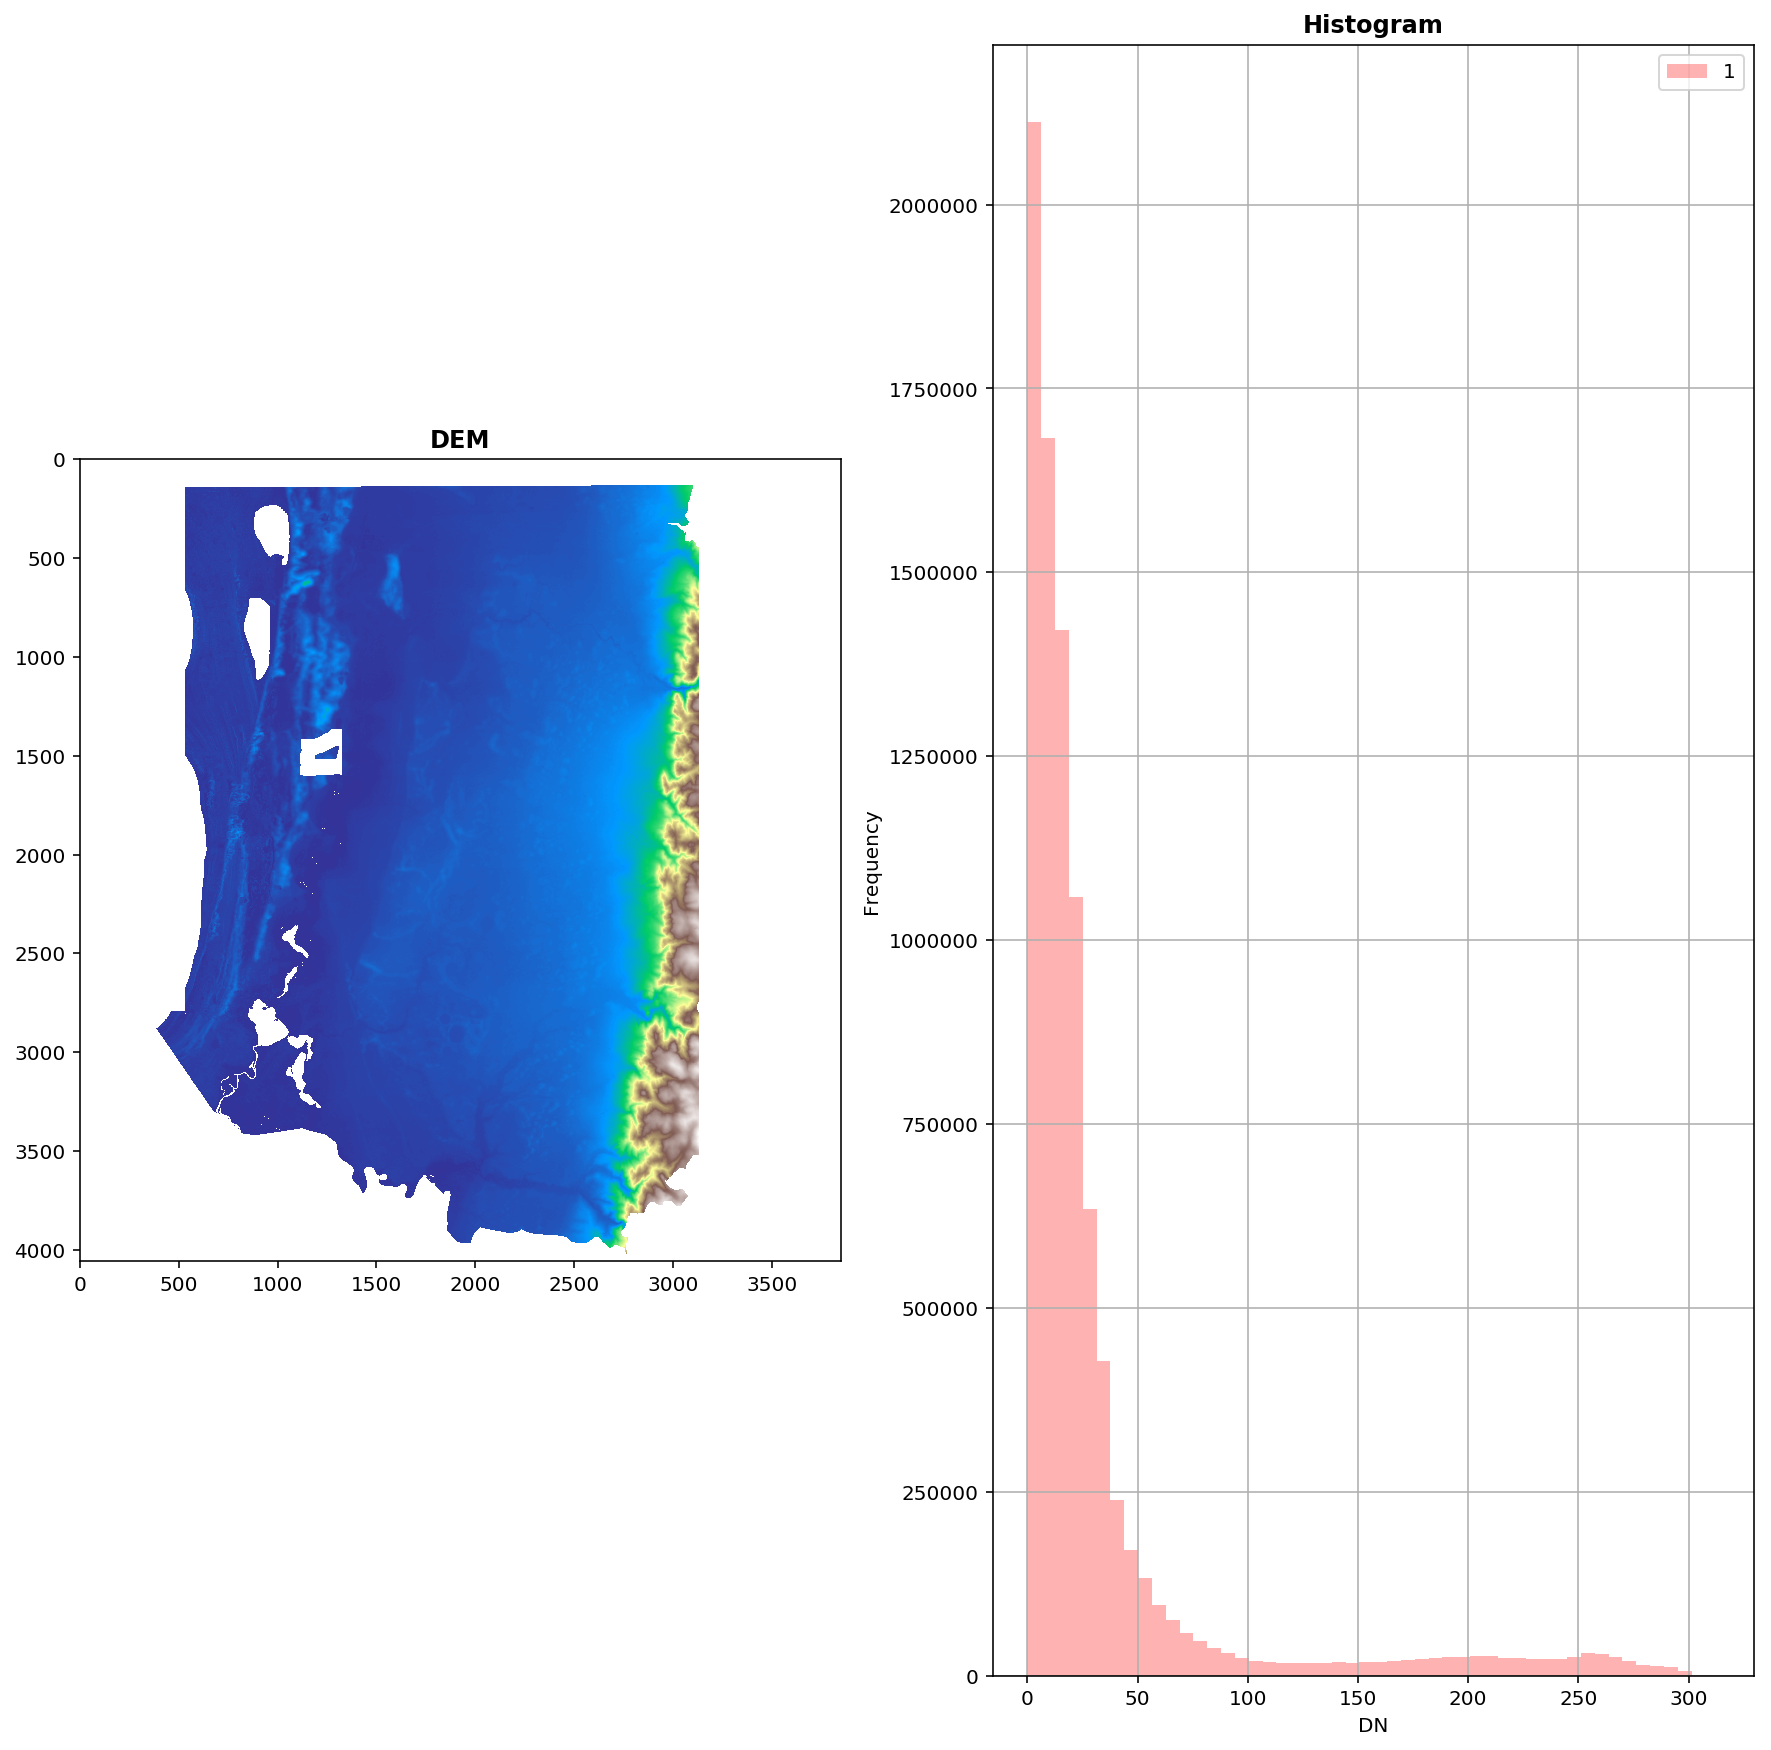

In [45]:
fig = plt.figure(figsize=(15, 15))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

show(dem,title='DEM', cmap='terrain',ax=ax1)
show_hist(dem, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram", ax=ax2)

In [46]:
band_1 = dem.read(1)

def read_elevation(dem,band_1,easting,northing):
    row, col = dem.index(easting,northing)
    return band_1[row,col]

def compute_AHD(row,dem):
    easting=row['Easting']
    northing=row['Northing']
    return read_elevation(dem,band_1,easting,northing)

In [47]:
df['DEM_elevation'] = df.apply (lambda row: compute_AHD(row,dem),axis=1)

In [48]:
df['Depth From (AHD)']=df['DEM_elevation']-df['Depth From (m)']
df['Depth To (AHD)']=df['DEM_elevation']-df['Depth To (m)']

In [49]:
df

Default Site  Reference  \
WIN Site ID                            
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2980                        61410018   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2982                        61410020   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2983                        61410021   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2984                        61410022   
2988                        61410026   
2988                        61410026   
2988                        61410026   
2988                        61410026   
...                              ...   
23087068                    61470062   
23087068                    61470062   
23087102                    61470077   
23087102                    61470077   
23087102                    61470077   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087123                    61470079   
23087142                    61470065   
23087142                    61470065   
23087146                    61470066   
23087146                    61470066   
23087146                    61470066   
23087147                    61470067   
23087147                    61470067   
23087147                    61470067   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087202                    61470068   
23087289                    61470083   
23087289                    61470083   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   
23087521                    61470084   

                                            Logged By    Log Date  \
WIN Site ID                                                         
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2980                             Authority Not Known   01/01/1900   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2982                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2983                                       

## Classify facies using 2D KNN algorithm (KNN=k-nearest neighbours)

In [50]:
from matplotlib import colors

def plot_lithologydata_slice_depth(slice_depth, n_neighbours):

    df_slice=df.loc[(df['Depth From (AHD)'] >= slice_depth) & (df['Depth To (AHD)'] <= slice_depth)]

    fig,ax=plt.subplots(1,1,figsize=(15,15),subplot_kw={'projection': ccrs.epsg(28350),'extent': extent})

    stamen_terrain = cimgt.StamenTerrain()
    ax.add_image(stamen_terrain, 11)
        
    ax.add_geometries(Reader(data_path + 'Cartopy/GWSA').geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='k',zorder=1)
    ax.add_geometries(Reader(data_path + 'Cartopy/PFZ_Boundary_DraftReport_ll').geometries(), ccrs.PlateCarree(),facecolor='none',edgecolor='r',zorder=1)

    for i, txt in enumerate(df_slice['Lithology_1'].values):
        plt.annotate(txt,(df_slice.Easting.values[i],df_slice.Northing.values[i]),fontsize=8,clip_on=True)
    
    for val,label in zip(ax.get_xticks(), ax.get_xticklabels()):
        label.set_text(str(val))
        label.set_position((val,0))  

    for val,label in zip(ax.get_yticks(), ax.get_yticklabels()):   
        label.set_text(str(val))
        label.set_position((0,val))  

    plt.tick_params(bottom=True,top=True,left=True,right=True,labelbottom=True,labeltop=False,labelleft=True,labelright=False)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)

    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')

    ax.grid(False)

    ax.text(0.1, 0.9, u'\u25B2 \nN ',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=25, 
    color='k',
    family='Arial',
    transform=ax.transAxes)
    
    plt.title('KNN facies classification at %s m AHD (neighbours=%s)'%(slice_depth,n_neighbours), fontsize=20, weight='bold')
    
    df_1=df_slice[df_slice.Lithology_1 != ""]
    X = df_1.as_matrix(columns=['Easting', 'Northing'])
    y = np.array(df_1['Lithology_1_num'])
    
    knn = neighbors.KNeighborsClassifier(n_neighbours, weights = 'distance').fit(X, y)
    
    grid_res=100
  
    # open shapefile
    GW_subareas=gpd.read_file(data_path + 'Cartopy/GWSA.shp')

    # reproject to epsg 28350
    GW_subareas['geometry'] = GW_subareas['geometry'].to_crs(epsg=28350)

    # max/min bounds
    x_min=GW_subareas.total_bounds[0]
    y_min=GW_subareas.total_bounds[1]
    x_max=GW_subareas.total_bounds[2]
    y_max=GW_subareas.total_bounds[3]
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_res),np.arange(y_min, y_max, grid_res))

    predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    predicted = predicted.reshape(xx.shape)
        
    plt.pcolormesh(xx, yy, predicted, cmap=lithology_cmap, norm=norm, alpha=0.3)
        
    ax.set_extent(near_field_extents, crs=data_proj)
    
interact_manual(plot_lithologydata_slice_depth, n_neighbours=IntSlider(min=1, max=30, step=1, value=10),slice_depth=FloatSlider(min=-100, max=30, step=1));

interactive(children=(FloatSlider(value=0.0, description=u'slice_depth', max=30.0, min=-100.0, step=1.0), IntSlider(value=10, description=u'n_neighbours', max=30, min=1), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [51]:
'"' + data_path + 'docs/Davidson.pdf' + '"'

'"/Users/JCastilla/Google Drive/CSIRO/Projects AU/PIWI/Modelling/docs/Davidson.pdf"'

In [52]:
from IPython.display import IFrame
IFrame('"' + data_path + 'docs/Davidson.pdf' + '"', width=1000, height=1200)

### Mayavi plots

In [53]:
from mayavi import mlab
%gui qt

#### Terrain plot

In [54]:
# open shapefile
GW_subareas=gpd.read_file(data_path + 'Cartopy/GWSA.shp')

# reproject to epsg 28350
GW_subareas['geometry'] = GW_subareas['geometry'].to_crs(epsg=28350)

# max/min bounds
x_min=GW_subareas.total_bounds[0]
y_min=GW_subareas.total_bounds[1]
x_max=GW_subareas.total_bounds[2]
y_max=GW_subareas.total_bounds[3]

grid_res=100
    
xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_res),np.arange(y_min, y_max, grid_res))

nrow, ncol = xx.shape

In [55]:
g=np.meshgrid(np.arange(x_min, x_max, grid_res),np.arange(y_min, y_max, grid_res))

points=np.vstack(map(np.ravel, g))

In [56]:
points.shape

(2, 73868)

In [57]:
num_points=points.shape[1]
num_points

73868

In [58]:
xx.shape

(313, 236)

In [59]:
z=[]

for point in np.arange(0,num_points):
    
    x=points[0,point]
    y=points[1,point]
    
    row, col = dem.index(x,y)

    result=band_1[row,col]
    
    z=np.append(z,result) 

In [60]:
z=z.clip(0)
z

array([   0.        ,    0.        ,    0.        , ...,   93.65000153,
         96.68000031,  104.02999878])

In [61]:
dem_array=z.reshape(xx.shape)

In [62]:
mlab.figure(size=(800, 800))

mlab.surf(xx.T, yy.T, np.flipud(z.reshape(xx.shape)), warp_scale=10, colormap='terrain')

mlab.outline()
mlab.show()

#### 2D KNN lithology block model using orthogonal cut planes

In [63]:
n_neighbours=10
AHD_min=-100
AHD_max=50

In [64]:
def plot_lithologydata_slice_depth_ITER(slice_depth, n_neighbours):

    df_slice=df.loc[(df['Depth From (AHD)'] >= slice_depth) & (df['Depth To (AHD)'] <= slice_depth)]

    df_1=df_slice[df_slice.Lithology_1 != ""]
    X = df_1.as_matrix(columns=['Easting', 'Northing'])
    y = np.array(df_1['Lithology_1_num'])
    
    knn = neighbors.KNeighborsClassifier(n_neighbours, weights = 'distance').fit(X, y)
    
    grid_res=100
    
    # open shapefile
    GW_subareas=gpd.read_file(data_path + 'Cartopy/GWSA.shp')

    # reproject to epsg 28350
    GW_subareas['geometry'] = GW_subareas['geometry'].to_crs(epsg=28350)

    # max/min bounds
    x_min=GW_subareas.total_bounds[0]
    y_min=GW_subareas.total_bounds[1]
    x_max=GW_subareas.total_bounds[2]
    y_max=GW_subareas.total_bounds[3]
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_res),np.arange(y_min, y_max, grid_res))

    predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    predicted = predicted.reshape(xx.shape)
    
    return predicted

Slice through geovolume, compute 2D KNN interpolation, stack results

In [65]:
#run once to obtain grid dimensions
current_slice=plot_lithologydata_slice_depth_ITER(0,10)

dim_x,dim_y=current_slice.shape

num_slices=len(np.arange(AHD_min,AHD_max,1))

lithology_3d_array=np.empty((dim_x,dim_y,num_slices))

# iterate over all slices
for index,AHD in enumerate(np.arange(AHD_min,AHD_max,1)):

    result=plot_lithologydata_slice_depth_ITER(AHD, n_neighbours)
    lithology_3d_array[:,:,index]=result

Work on copy of original block model

In [66]:
test=np.copy(lithology_3d_array)
test=np.flip(test,axis=2)

Burn DEM into grid

In [67]:
for row in np.arange(0,313,1):
    for column in np.arange(0,236,1):
        
        erode_until=-(dem_array.astype(int)-30)[row,column]
        
        if erode_until > 0:
                    
            test[row,column,0:erode_until]=np.nan

Plot

In [68]:
mlab.figure(size=(800, 800))

s = np.flip(np.flip(test,axis=2), axis=0)

x_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='x_axes',
                            slice_index=20, colormap='terrain',  
                        )
y_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='y_axes',
                            slice_index=20, colormap='terrain'
                        )
z_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='z_axes',
                            slice_index=20, colormap='terrain'
                        )
mlab.outline()
mlab.ylabel('Easting')
mlab.xlabel('Northing')
mlab.zlabel('mAHD')

mlab.scalarbar(nb_labels=15)

x_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0
y_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0
z_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0

mlab.show()

## Probability estimates for classes

In [77]:
def plot_lithologydata_slice_depth_ITER_CLASSPROB(slice_depth, n_neighbours):

    df_slice=df.loc[(df['Depth From (AHD)'] >= slice_depth) & (df['Depth To (AHD)'] <= slice_depth)]

    df_1=df_slice[df_slice.Lithology_1 != ""]
    X = df_1.as_matrix(columns=['Easting', 'Northing'])
    y = np.array(df_1['Lithology_1_num'])

    ### NEED TO APPEND DUMMY DATA TO MAKE SURE ALL CLASSES ARE PRESENT IN EACH SLICE ###
    dummy_EN=np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
    dummy_targets=np.array([[0],[1],[2],[3],[4],[5],[6]])

    X=np.vstack((X,dummy_EN))
    y=np.append(y,dummy_targets)

    knn = neighbors.KNeighborsClassifier(n_neighbours, weights = 'distance').fit(X, y)

    grid_res=100

    # open shapefile
    GW_subareas=gpd.read_file(data_path + 'Cartopy/GWSA.shp')

    # reproject to epsg 28350
    GW_subareas['geometry'] = GW_subareas['geometry'].to_crs(epsg=28350)

    # max/min bounds
    x_min=GW_subareas.total_bounds[0]
    y_min=GW_subareas.total_bounds[1]
    x_max=GW_subareas.total_bounds[2]
    y_max=GW_subareas.total_bounds[3]

    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_res),np.arange(y_min, y_max, grid_res))

    # 0=sand
    # 1=sandstone 
    # 2=clay
    # 3=limestone
    # 4=shale
    # 5=basalt
    # 6=coffee rock
    
    class_prob = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    
    class_prob = class_prob.reshape(313,236)
    
    return class_prob

In [78]:
#run once to obtain grid dimensions
current_slice=plot_lithologydata_slice_depth_ITER_CLASSPROB(0,10)

dim_x,dim_y=current_slice.shape

num_slices=len(np.arange(AHD_min,AHD_max,1))

classprob_3d_array=np.empty((dim_x,dim_y,num_slices))

# iterate over all slices
for index,AHD in enumerate(np.arange(AHD_min,AHD_max,1)):

    result=plot_lithologydata_slice_depth_ITER_CLASSPROB(AHD, n_neighbours)
    classprob_3d_array[:,:,index]=result

In [79]:
test=np.copy(classprob_3d_array)
test=np.flip(test,axis=2)

In [80]:
for row in np.arange(0,313,1):
    for column in np.arange(0,236,1):
        
        erode_until=-(dem_array.astype(int)-30)[row,column]
        
        if erode_until > 0:
                    
            test[row,column,0:erode_until]=np.nan

In [81]:
from mayavi import mlab
import numpy as np

colormap='magma'

mlab.figure(size=(800, 800))

s = np.flip(np.flip(test,axis=2), axis=0)

x_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='x_axes',
                            slice_index=20, colormap=colormap,  
                        )
y_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='y_axes',
                            slice_index=20, colormap=colormap
                        )
z_cut=mlab.pipeline.image_plane_widget(mlab.pipeline.scalar_field(s),
                            plane_orientation='z_axes',
                            slice_index=20, colormap=colormap
                        )
mlab.outline()
mlab.ylabel('Easting')
mlab.xlabel('Northing')
mlab.zlabel('mAHD')
mlab.title('Coffee Rock')

mlab.scalarbar(nb_labels=15)

x_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0
y_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0
z_cut.module_manager.scalar_lut_manager.lut.nan_color = 0, 0, 0, 0

mlab.show()

# SANDBOX/TESTING

## Evaluate the KNN classifier

### Train/Test split and validation report

In [82]:
slice_depth=-10
df_slice=df.loc[(df['Depth From (AHD)'] >= slice_depth) & (df['Depth To (AHD)'] <= slice_depth)]

In [83]:
df_slice

Default Site  Reference  \
WIN Site ID                            
2980                        61410018   
2982                        61410020   
2983                        61410021   
2984                        61410022   
2988                        61410026   
2989                        61410027   
2991                        61410029   
2993                        61410031   
2994                        61410032   
3009                        61410047   
3011                        61410049   
3020                        61410058   
3021                        61410059   
3023                        61410061   
3024                        61410062   
3025                        61410063   
3026                        61410064   
3027                        61410065   
3032                        61410070   
3033                        61410071   
3035                        61410073   
3036                        61410074   
3042                        61410080   
3043                        61410081   
3050                        61410088   
3052                        61410090   
3053                        61410091   
3055                        61410093   
3056                        61410094   
3078                        61410116   
...                              ...   
20083887                    61405884   
20084061                    61405888   
20084062                    61405889   
20084063                    61405890   
20084064                    61405891   
20084069                    61405896   
20084070                    61405897   
20084087                    61405914   
20084174                    61405942   
20084176                    61405944   
20084180                    61405948   
20084181                    61405949   
20084184                    61405952   
20084185                    61405953   
20084186                    61405954   
20084192                    61405960   
20084372                    61405986   
23042166                    61407115   
23086802                    61470051   
23087049                    61470056   
23087051                    61470058   
23087057                    61470061   
23087068                    61470062   
23087102                    61470077   
23087123                    61470079   
23087142                    61470065   
23087146                    61470066   
23087147                    61470067   
23087202                    61470068   
23087521                    61470084   

                                            Logged By    Log Date  \
WIN Site ID                                                         
2980                             Authority Not Known   01/01/1900   
2982                                        Allen A D  20/06/1975   
2983                                        Allen A D  20/06/1975   
2984                                        Allen A D  11/02/1977   
2988                             Authority Not Known   30/06/1975   
2989                             Authority Not Known   30/06/1975   
2991                             Authority Not Known   30/06/1975   
2993                                        Allen A D  13/06/1975   
2994                                        Allen A D  13/06/1975   
3009                             Authority Not Known   30/06/1975   
3011                             Authority Not Known   30/06/1975   
3020                             Authority Not Known   30/06/1975   
3021                             Authority Not Known   30/06/1975   
3023                                        Allen A D  25/06/1975   
3024                                        Allen A D  25/06/1975   
3025                                        Allen A D  02/07/1975   
3026                                        Allen A D  02/07/1975   
3027                                        Allen A D  12/08/1975   
3032                             Authority Not Known   30/06/1975   
3033                             Authority 

In [84]:
df_1=df_slice[df_slice.Lithology_1 != ""]
X = df_1.as_matrix(columns=['Easting', 'Northing'])
y = np.array(df_1['Lithology_1'])

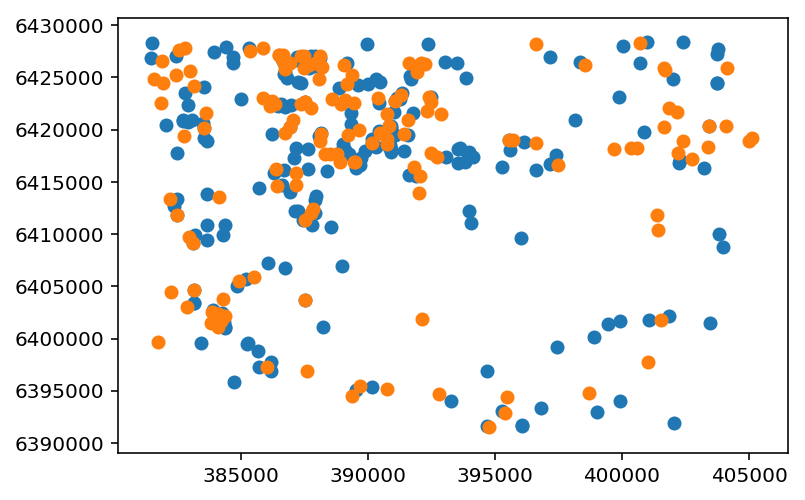

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
plt.scatter(X_train[:,0],X_train[:,1])
plt.scatter(X_test[:,0],X_test[:,1])

In [86]:
knn = neighbors.KNeighborsClassifier(10, weights = 'distance').fit(X_train, y_train)

In [87]:
knn.score(X_test,y_test)

0.54000000000000004

In [88]:
predicted = knn.predict(X_test)

In [89]:
print (metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

       clay       0.35      0.26      0.30        23
  limestone       0.53      0.57      0.55        28
       sand       0.59      0.71      0.65        73
  sandstone       0.56      0.38      0.45        13
      shale       0.33      0.15      0.21        13

avg / total       0.52      0.54      0.52       150



###  k-fold cross validation

In [ ]:
test_size=0.1          #train/test split
N_repetitions=50       #number of training sets to generate
N_folds=10             #train/validate split for kfold validation
neighbours=np.arange(1,50,1)
all_scores = np.zeros(shape=(N_repetitions,len(neighbours)))

for training_set in np.arange(0,N_repetitions,1):
    
    cv_scores = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # perform k-fold cross validation
    for k in neighbours:
        knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights = 'distance')
        scores = cross_val_score(knn, X_train, y_train, cv=N_folds, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    all_scores[training_set,:]=np.asarray(cv_scores)
    
plt.plot(neighbours, 1-all_scores.mean(0))
plt.xlabel('Number of Neighbors K', weight='bold')
plt.ylabel('Misclassification Error', weight='bold')

In [ ]:
cv_scores = []

# perform k-fold cross validation
for k in neighbours:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbours[MSE.index(min(MSE))]
print ("The optimal number of neighbours is %s" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbours, MSE)
plt.xlabel('Number of Neighbors K', weight='bold')
plt.ylabel('Misclassification Error', weight='bold')
plt.show()

## NLTK Natural Language Processing

### Tokenize

In [ ]:
df['tokenized_text'] = df['Lithological Description'].apply(nltk.word_tokenize)

### Apply part-of-speech tags

In [ ]:
df['pos_tagged'] = df['tokenized_text'].apply(nltk.pos_tag)

In [ ]:
df['pos_tagged'][3067].iloc[7]

In [ ]:
df.plot(columns='Depth From (m')

## Kh — fitted Lognormal distributions 

In [ ]:
pwd

In [69]:
def plot_lognormal(s_par):

    plt.figure(figsize=(10,10))
    x = np.linspace(lognorm.ppf(0.01, s_par), lognorm.ppf(0.99, s_par), 100)
    plt.title('Lognormal distribution (s=%s)'%(s_par), size=20, weight='bold')
    plt.plot(x, lognorm.pdf(x, s_par),'k-', lw=2, alpha=1, label='lognormal pdf')
    
s_DROPDOWN = widgets.FloatSlider(min=0, max=20, step=0.01, value=1)

w=widgets.interact_manual(plot_lognormal,s_par=s_DROPDOWN)
display(w)

interactive(children=(FloatSlider(value=1.0, description=u's_par', max=20.0, step=0.01), Button(description=u'Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_lognormal>

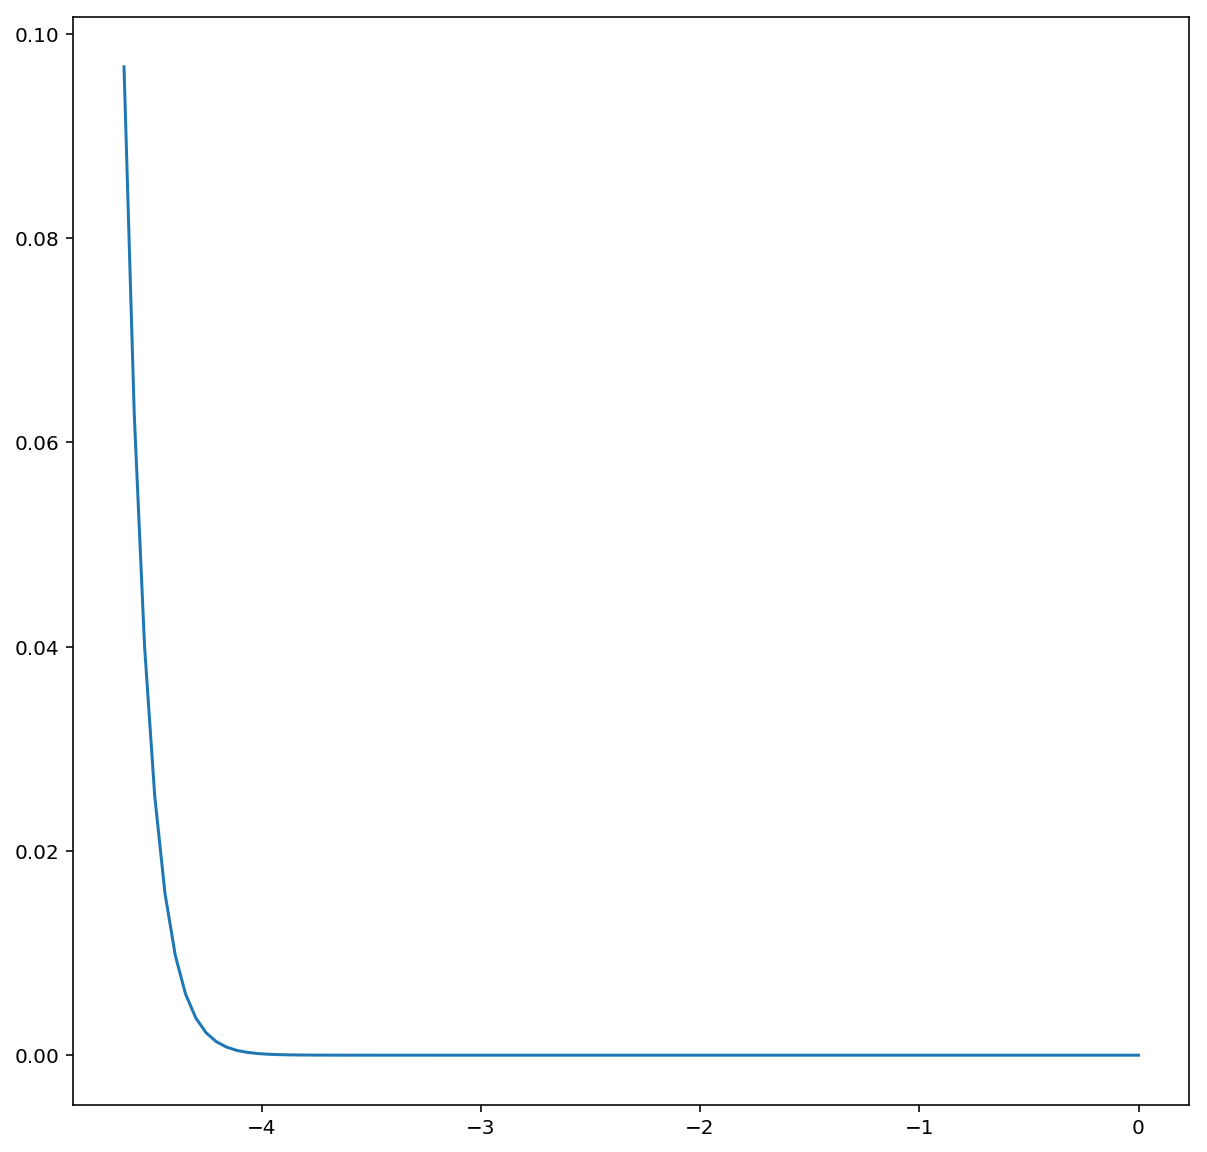

In [70]:
mu=-6.150515
sigma=0.180860

dist=lognorm(sigma,loc=mu)

plt.figure(figsize=(10,10))

x=np.linspace(0,lognorm.ppf(0.99, sigma, loc=mu),100)

plt.plot(x,dist.pdf(x))
#plt.plot(x,dist.cdf(x))

### Find parameters for a normal random variable X so that P(X < x1) = p1 and P(X < x2) = p2.

In [73]:
def normal_parameters(x1, p1, x2, p2):
    denom = stats.norm.ppf(p2) - stats.norm.ppf(p1)
    sigma = (x2 - x1) / denom
    mu = (x1*stats.norm.ppf(p2) - x2*stats.norm.ppf(p1)) / denom
    return (mu, sigma)

In [74]:
df_K_ranges=pd.read_excel(data_path + '/lithology_analysis/Input_data.xlsx',skiprows=3, sheet='K_ranges')
df_K_ranges

Material          Kmin          Kmax  Log_Kmin  Log_Kmax
0                        clay  5.000000e-08       0.00001  -7.30103        -5
1                glacial till  1.000000e-07       0.00100  -7.00000        -3
2                        silt  1.000000e-04       1.00000  -4.00000         0
3                  silty sand  5.000000e-03     100.00000  -2.30103         2
4                        sand  1.000000e-01    1000.00000  -1.00000         3
5                      gravel  1.000000e+02  100000.00000   2.00000         5
6                       shale  1.000000e-11       0.00010 -11.00000        -4
7   igneous/metamorphic rocks  1.000000e-09      10.00000  -9.00000         1
8                   sandstone  1.000000e-05       1.00000  -5.00000         0
9          limestone/dolomite  5.000000e-05    1000.00000  -4.30103         3
10           fractured basalt  1.000000e-02    1000.00000  -2.00000         3

In [75]:
p1=0.0000000001
p2=0.9999999999

for i, row in df_K_ranges.iterrows():
    
    x1=row['Log_Kmin']
    x2=row['Log_Kmax']
    
    mu,sigma = normal_parameters(x1, p1, x2, p2)
    
    df_K_ranges.set_value(i,'mu',mu)
    df_K_ranges.set_value(i,'sigma',sigma)
    
df_K_ranges   

/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/JCastilla/anaconda2/envs/MODELLING/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Material          Kmin          Kmax  Log_Kmin  Log_Kmax  \
0                        clay  5.000000e-08       0.00001  -7.30103        -5   
1                glacial till  1.000000e-07       0.00100  -7.00000        -3   
2                        silt  1.000000e-04       1.00000  -4.00000         0   
3                  silty sand  5.000000e-03     100.00000  -2.30103         2   
4                        sand  1.000000e-01    1000.00000  -1.00000         3   
5                      gravel  1.000000e+02  100000.00000   2.00000         5   
6                       shale  1.000000e-11       0.00010 -11.00000        -4   
7   igneous/metamorphic rocks  1.000000e-09      10.00000  -9.00000         1   
8                   sandstone  1.000000e-05       1.00000  -5.00000         0   
9          limestone/dolomite  5.000000e-05    1000.00000  -4.30103         3   
10           fractured basalt  1.000000e-02    1000.00000  -2.00000         3   

          mu     sigma  
0  -6.150515  0.180860  
1  -5.000000  0.314399  
2  -2.000000  0.314399  
3  -0.150515  0.338060  
4   1.000000  0.314399  
5   3.500000  0.235799  
6  -7.500000  0.550198  
7  -4.000000  0.785998  
8  -2.500000  0.392999  
9  -0.650515  0.573859  
10  0.500000  0.392999

### Plot family PDFs and CDFs for K

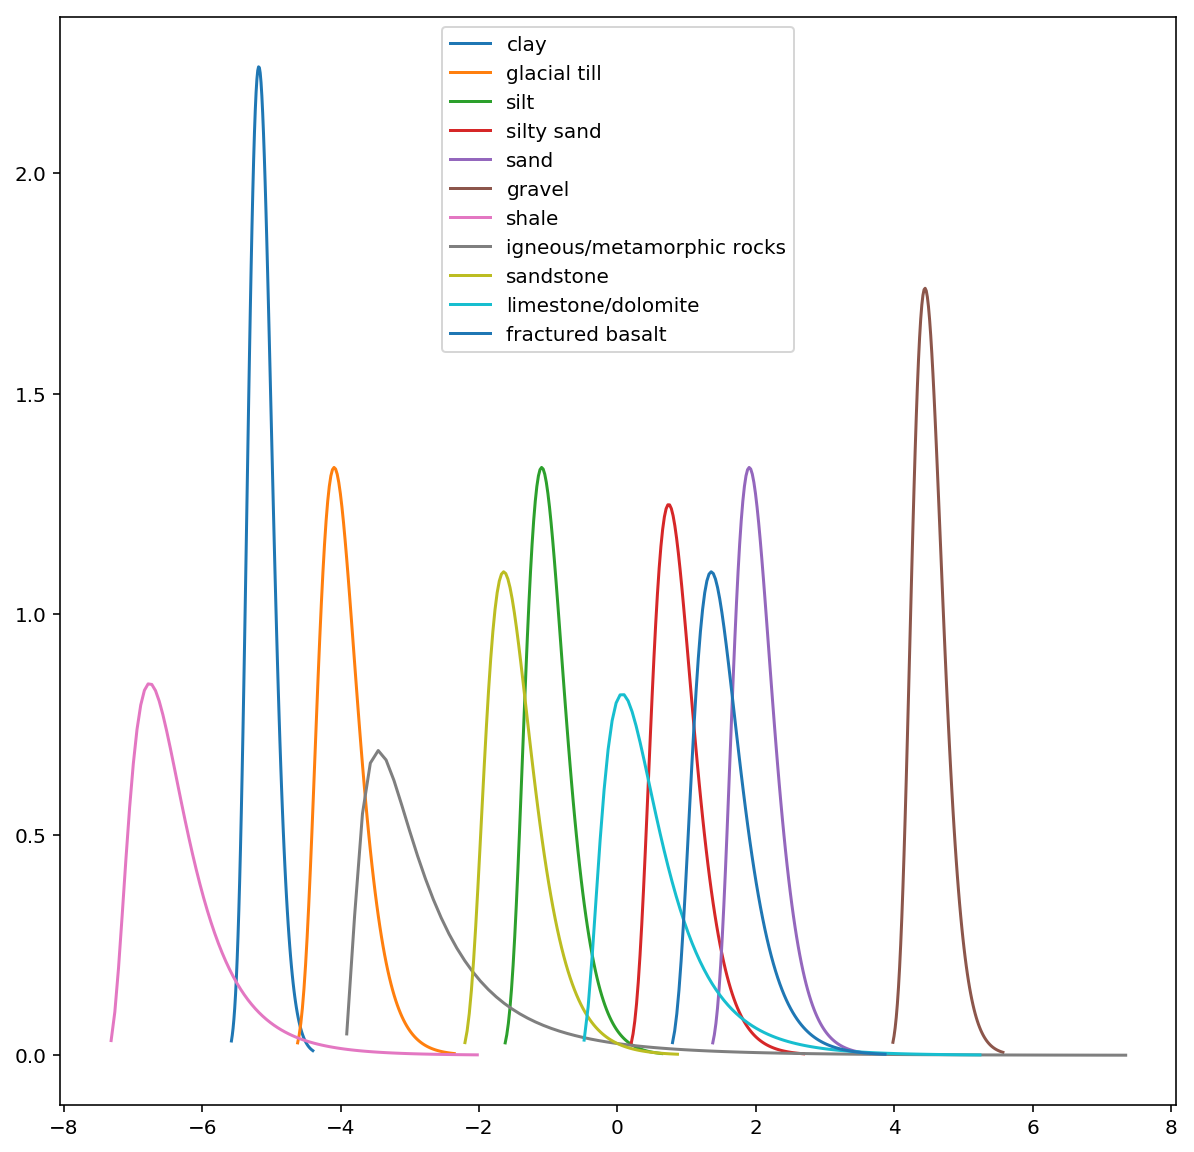

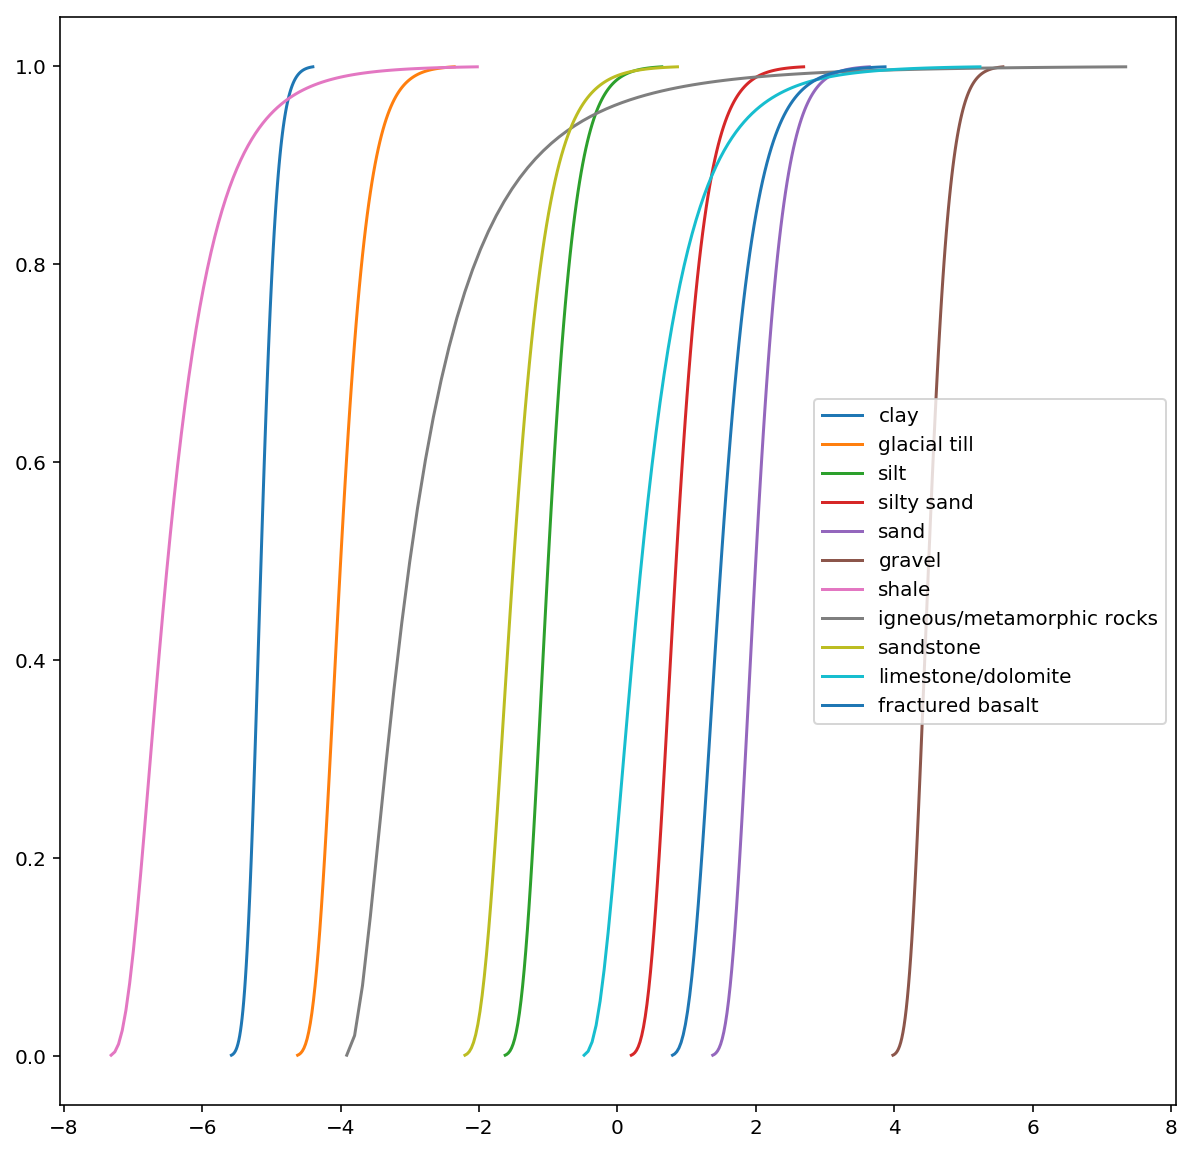

In [76]:
plt.figure(figsize=(10,10))

for i, row in df_K_ranges.iterrows():
    
    mu=row['mu']
    sigma=row['sigma']
    
    dist=lognorm(sigma,loc=mu)
    
    x=np.linspace(lognorm.ppf(0.001, sigma, loc=mu),lognorm.ppf(0.999, sigma, loc=mu),100)
 
    plt.plot(x,dist.pdf(x), label=row['Material'])
    plt.legend()

plt.figure(figsize=(10,10))

for i, row in df_K_ranges.iterrows():
    
    mu=row['mu']
    sigma=row['sigma']
    
    dist=lognorm(sigma,loc=mu)
    
    x=np.linspace(lognorm.ppf(0.001, sigma, loc=mu),lognorm.ppf(0.999, sigma, loc=mu),100)
 
    plt.plot(x,dist.cdf(x), label=row['Material'])
    plt.legend()

In [ ]:
x

## Striplog library lexicon

https://github.com/agile-geoscience/striplog

In [90]:
striplog_lexicon={'abbreviations': {'Bld': 'boulder', 'Poln': 'pollen', 'Ltl': 'little', 'Bry': 'bryozoa', 'Grap': 'graptolite', 'tub': 'tubular', 'aph': 'aphanitic', 'Cor': 'coral', 'crbnt': 'carbonate', 'exclas': 'extraclastic', 'pyr': 'pyritized', 'S.W.': 'salt water', 'vrtl': 'vertical', 'Mdst': 'mudstone', 'SOCM': 'slight oil cut mud', 'brt': 'bright', 'mod': 'moderate', 'sm': 'smooth', 'mrly': 'marly', 'Phyl': 'phyllite', 'Chara': 'charophytes', 'or': 'orangish', 'gept': 'geopetal', 'flky': 'flaky', 'anhy': 'anhydritic', 'Deer': 'decrease', 'Qtzt': 'quartzite', 'mdy': 'muddy', 'Stach': 'stachyodes*', 'cmt': 'cemented', 'Sa': 'salt', 'gy': 'gray', 'perm': 'permeability', 'rhb': 'rhombic', 'sdy': 'sandy', 'Char': 'charophyte', 'pch': 'patchy', 'fl': 'filled', 'Mtrx': 'matrix', 'O str': 'Ostracod', 'sil': 'siliceous', 'dissem': 'disseminated', 'G&OCM': 'gas and oil cut mud', 'psool': 'pseudo oolitic', 'Strom': 'stromatoporoid', 'recem': 'recemented', 'rsns': 'resinous', 'volc': 'volcanics', 'Sedm': 'sediment', 'sc': 'scales', 'Slick slick': 'slickenside', 'm': 'medium', 'Rk': 'rock', 'Smwt': 'somewhat', 'Iran': 'granule', 'tgh': 'tough', 'fl/': 'flowing', 'FIt': 'fault', 'venn': 'vermillon', 'vit': 'vitreous', 'Spfool': 'superficial olite', 'Allo': 'allochem', 'tn': 'tan', 'Lut': 'lutite', 'Lith': 'lithology', 'pris': 'prismatic', 'SI': 'shut in', 'Sol': 'Soution', 'mass': 'massive', 'Tr': 'trace', 'deb': 'debris', 'drsy': 'drusy', 'med.': 'medium', 'p.p.': 'pin-poin', 'Bas': 'basalt', 'Chlor': 'chlorite', 'gr': 'grained', 'Orbit': 'Orbitolina', 'Ooc': 'oolicast', 'LL': 'laterolog', 'MLL': 'microlaterolog', 'Wtr': 'water', 'g': 'good', 'crd': 'cored', 'intfrag': 'interfragmental', 'Cont': 'content', 'HO': 'heavy oil', 'pk': 'pink', 'lt': 'lighter', 'xbd': 'cross-bedded', 'Pel': 'pellet', 'cntrt': 'contorted', 'intpar': 'interparticle', 'Tub': 'tube', 'Ls': 'limestone', 'phos': 'phosphatic', 'Repl': 'replaced', 'var': 'variable', 'meta': 'metamorphic', 'boudg': 'boudinage', 'bu': 'buff', 'bit': 'bitumeninous', 'crpld': 'crumpled', 'lav': 'lavender', 'gns': 'gneiss', 'od': 'odor', 'vi': 'violet', 'Gr': 'grains', "'' or do": 'ditto', 'depau': 'depauperate', 'SAB': 'strong air blow', 'contm': 'contaminated', 'Foss': 'fossiliferous', 'porcel': 'porcelaneous', 'Oyst': 'oyster', 'sltst': 'siltstone', 'Glos': 'gloss', 'IES': 'induction electric', 'Plag': 'plagioclase', 'ox': 'oxidized', 'Sd': 'sand', 'Intst': 'intersticies', 'magnt': 'magnetite', 'rng': 'range', 'ahd': 'anhedral', 'loc': 'location', 'stal': 'stalactitic', 'rnd': 'rounded', 'Sid': 'siderite', 'rep': 'replacedment', 'Euryamph': 'euryamphipora*', 'lithgr': 'lithographic', 'ireg': 'irregular', 'bo': 'bophaceous', 'Fau': 'fauna', 'Arag': 'aragonite', 'biocl': 'bioclastic', 'Oomol': 'oomold', 'sid': 'sideritic', 'hem': 'hematitic', 'flg': 'flaggy', 'r': 'rare', 'tstg': 'testing', 'fenst': 'fenestral', 'deer': 'decreasing', 'Rem': 'remains', 'SGCM': 'slight gas cut mud', 'Port por': 'porosity', 'grnt.w': 'granite wash', 'phr': 'phreatic', 'glos': 'glossy', 'comp': 'completion', 'euhd': 'euhedral', 'devit': 'devitrified', 'Cav': 'cavernous', 'pol': 'polished', 'chty': 'cherty', 'imbd': 'imbedded', 'bor': 'boreding', 'W': 'west', 'lse': 'loose', 'bioh': 'biohermal', 'conspic': 'conspicuous', 'plty': 'platy', 'uncons': 'unconsolidated', 'lmpy': 'lumpy', 'abnt': 'abundant', 'ga': 'gauged', 'sml': 'small', 'Grt': 'granite', 'Scs': 'scarce', 'G.W.': 'granite wash', 'Clclt': 'calcilutite', 'cren': 'crenulated', 'lge': 'large', 'BHT': 'bottom hole temperature', 'Mbl': 'marble', 'brak': 'brackish', 'mnut': 'minute', 'n': 'no, none, non', 'Spo': 'spore', 'lmy': 'limy', 'gen': 'generally', 'Trip': 'tripoli', 'Incl': 'inclusion', 'BW': 'barrels of water', 'cb': 'carbonized', 'Sst': 'sandstone', 'sd': 'sand (1/16-2 mm)', 'S.W.C.': 'sidewall core', 'Fen': 'fenestra', 'TSTM': 'too small to measure', 'DST': 'drill stem test', 'intpt': 'interpretation', 'O&SW': 'oil and salt water', 'sh': 'shale', 'Vnlet': 'veinlet', 'Shlt por': 'shelter porosity', 'Nod': 'nodules', 'mat': 'material, matter', 'cons': 'considerable', 'FAB': 'fair air blow', 'dist': 'distillate', 'Pch': 'patch', 'elg': 'elongate', 'Lyr': 'layer', 'Schm': 'schist', 'cotd': 'coateding', 'Microstyl': 'microstylolite', 'cht': 'chert', 'Lstr': 'lustre', 'spec': 'speckled', 'FTAB': 'faint air blow', 'Gyp': 'gypsumiferous', 'Dol': 'dolomite', 'Ctgs': 'cuttings', 'phen': 'phenocrysts', 'aren': 'arenaceous', 'Clvg': 'cleavage', 'carb': 'carbonaceous', 'Strk': 'streak', 'Volc': 'volcanic', 'coqid': 'coquinaoid', 'lac': 'lacustrine', 'lrg': 'larger', 'prly': 'pearly', 'Rbl': 'rubble', 'srt': 'sorting', 'alg': 'algal', 'Wkst': 'wackestone', 'OTS': 'oil to surface', 'p.d': 'pressure deformation', 'bar': 'baritic', 'AOF': 'absolute open flow', 'dtrl': 'detritalus', 'aglm': 'agglomerate', 'euhed': 'euhedral', 'Gast': 'gastropod', 'Foram': 'foraminifera', 'lim': 'itic', 'su': 'sulphurous', '(W)': 'wildcat', 'mag': 'magnetic', 'frg': 'fringing', 'col': 'colored', 'pbl': 'pebble (4-64 mm)', 'hkl': 'hackly', 'Mic': 'micaceous', 'Xl': 'crystal', 'cub': 'cubic', 'bdg': 'bedding', 'intgn': 'inter grown', 'DF': 'derrick floor', 's&p': 'salt & pepper', 'intxln': 'intercrystalline', 'contam': 'contaminated', 'marn': 'marine', 'Circ': 'circulate', 'mar': 'maroon', 'intst': 'intersticitial', 'stri': 'striated', 'oom': 'oomoldic', 'E': 'east', 'KB': 'kelly bushing', 'GOR': 'gas-to-oil ratio', '&': 'and', 'Fp': 'flowing pressure', 'uncons.': 'unconsolidated', 'min': 'mineralized', 'Solen': 'solenopora*', 'Slt': 'silt', 'ck': 'choke', 'Girv': 'girvanella*', 'DI': 'dual induction log', 'WCM': 'water cut mud', 'Zr': 'zircon', 'Belm': 'belemnites*', 'bdd': 'bedded', 'chk': 'chalky', 'Meta': 'metamorphic rock', 'spkld': 'speckled', 'Var': 'variation', 'micr': 'micritic', 'apprx': 'approximate', 'Invtb': 'invertebrate', 'bl': 'bluish', 'men': 'meniscus', 'Tex': 'texture', 'Frac': 'fracture', 'acic': 'acicular', 'sel': 'selenite', 'crinal': 'crinoidal', 'Glob': 'globigerina*', 'sqz': 'squeezed', 'fib': 'fibrous', 'rug': 'rugosa', 'coln': 'colonial', 'Rad': 'radial', 'magn': 'magnetic', 'Bioh': 'bioherm', 'Fluor': 'fluoresceince', 'posa': 'possible', 'Scol': 'scolecodonts', 'sli': 'slightly', 'Lam': 'laminations', 'Fe-st': 'ironstone', 'Fac': 'facet', 'detr': 'detrital', 'PH': 'per hour', 'dom': 'dominant', 'Orth': 'orthoclase', 'ctc': 'contact', 'fol': 'foliated', 't.b.': 'thin-bedded', 'rndd': 'rounded', 'Sil': 'silica', 'gl': 'glassy', 'Mat': 'material', 'micropor': 'microporosity', 'Flk': 'flake', 'eux': 'euxinic', 'Phlog': 'phloaopite', 'circ': 'circulation', 'tr': 'trace', 'tex': 'texture', 'sks': 'slickensided', 'GIP': 'good initial puff', 'cov': 'covered', 'MCO': 'mud cut oil', 'Pap': 'paper', 'Glas': 'glass', 'PPM': 'parts per million', 'bas': 'basaltic', 'ls': 'limestone', 'V.P.S.': 'very poor sample V.P.S.', 'Micropor': 'micropore', 'Aglm': 'agglomerate', 'cly': 'clayey', 'In': 'inch', 'poly': 'polygonal', 'SSO': 'slight show of oil', 'lmn': 'limonitic', 'Grv': 'gravel', 'flor': 'fluorescence', 's': 'small', 'Clcar': 'calcarenite', 'OCM': 'oil cut mud', 'decr': 'decreasing', 'rhmb': 'rhombic', 'Pisol': 'pisolite', 'p-p': 'pin point', 'stn': 'staining', 'frmwk': 'framework', 'arg': 'argillaceous', 'Tp': 'top', 'Cl': 'clay', 'med': 'medium', 'rexl': 'recrystallization', 'slb': 'slabby', 'Rhb': 'rhomb', 'Wl': 'well', 'Qtz': 'quartz', 'crpxln': 'crystocrystalline', 'max': 'maximum', 'Flo': 'flora', 'crnk': 'crinkled', 'sa': 'salt', 'Ptg': 'parting', 'sed': 'sedimentary', 'Gal': 'galeolaria*', 'SOCW': 'slight oil cut water', 'blk': 'black', 'stromlt': 'stromatolite', 'syn': 'syntaxial', 'chit': 'chitinous', 'T.D.': 'total depth', 'vug': 'vugular', 'clr': 'clear', 'org': 'organic', 'eqnt': 'equant', 'sz': 'size', 'jt': 'jointing', 's & p': 'salt and pepper', 'vert': 'vertical', 'abv': 'above', '(D)': 'development', 'ab': 'above', 'Par': 'particle', 'calctc': 'calcitic', 'authg': 'authigenic', 'extr': 'extremely', 'n.v.p.': 'no visible porosity', 'rdsh': 'redish', 'fr': 'fair', 'lam': 'laminated', 'Slst': 'siltstone', 'up': 'upper', 'pt': 'partly', 'grd': 'graded', 'glas': 'glassy', 'O-Qtz': 'orthoquartzite', 'plag': 'plagioclase', 'rbl': 'rubblbly', 'micgr': 'micrograined', 'unident': 'unidentifiable', 'Ctc': 'contact', 'vcol': 'varicolored', 'Mol': 'mollusca', 't.s.': 'thin section', 'Intvl': 'interval', 'Tas': 'tasmanites*', 'fau': 'fauna', 'cgl': 'conglomerate', 'vps': 'very poor samples', 'Microol': 'micro-oolite', 'bld': 'bladed', 'uni': 'uniform', 'rd': 'rounded', 'Sh': 'shale', 'Satm sat': 'saturation', 'alt': 'altering', 'Stn': 'stain', 'ES': 'electric', 'LL8': 'laterolog-8', 'Gns': 'gneiss', 'Pt': 'part', 'intrapar': 'intraparticle', 'volat': 'volatile', 'orsh': 'orangish', 'repl': 'replacement', 'app': 'appear', 'mky': 'milky', 'dkr': 'darker', 'grnt': 'granite', 'argl': 'argillate', 'qtzc': 'quartzitic', 'Elev': 'elevation', 'irr': 'irregular', 'lith': 'lithographic', 'spl': 'sample', 'cotd gn': 'coated grains', 'lg': 'long', 'blky': 'blocky', 'Bot': 'botryoid', 'Onc': 'oncolite', 'por': 'poroussity', 'fac': 'faceted', 'Tent': 'tentaculites*', 'intxl': 'intercrystalline', 'sb': 'sub', 'x': 'cross', 'Descr': 'description', 'Ft': 'foot', 'intclas': 'intraclastic', 'bur': 'burrowed', 'ss': 'sandstone', 'rthy': 'earthy', 'lent': 'lenticular', 'Assem': 'Assem', 'sim': 'similar', 'x-lam': 'cross-laminated', 'Cbl': 'cobble', 'vgt': 'varigated', 'rad': 'radiating', 'bcm': 'becoming', 'MCW': 'mud cut water', 'Pend': 'pendularous', 'surf': 'surface', 'LSD': 'legal subdivision', 'stmg': 'streaming', 'frag': 'fragmental', 'Splin': 'splintery', 'grapst': 'grapestone', 'microxln': 'microcrystalline', 'abs': 'absent', 'assoc': 'associated', 'ark': 'arkosic', 'Jasp': 'jasper', 'csg': 'casing', 'exp': 'exposed', 'Moll': 'mollusc', 'sacc': 'saccharoidal', 'Pbl': 'pebble', 'blksh': 'blackish', 'Stylio': 'styliolina*', 'indst': 'indistinct', 'aft': 'after', 'Microfos': 'microfossilferous', 'litt': 'littoral', 'thk': 'thick', 'Biot': 'biotite', 'fibr': 'fibrous', 'hvy': 'heavy', 'nod': 'nodule', 'rec': 'recovered', 'olvn': 'olivine', 'Mrl': 'marl', 'calc': 'calcitareous', 'flk': 'flake', 'Bit': 'bitumen', 'dk': 'darker', 'Vn': 'vein', 'cotg': 'coateding', 'SNP': 'sidewall neutron porosity log', 'brit': 'brittle', 'lit': 'lithic', 'consol': 'consolidated', 'altg': 'alternating', 'sy-Ca': 'sparry calcite', 'anhed': 'anhedral', 'Vad': 'vadose', 'Stri': 'striae', 'W.R.': 'washed residue', 'Hem': 'hematite', 'embd': 'embedded', 'bnd': 'banded', 'SGCW': 'slight gas cut water', 'lig': 'lignitic', 'spr': 'sparry', 'wtr cush': 'water cushion', 'ex': 'excellent', 'Fspr': 'feldspar', 'psdo': 'pseudo', 'mott': 'mottled', 'Vug': 'vug', 'Fe': 'iron-ferruginous', 'spher': 'spherulitic', 'strk': 'streaked', 'Bdst': 'boundstone', 'Fuc': 'fucoid', 'fspr': 'feldsparathic', 'trnsp': 'transparent', 'tab': 'tabular', 'IAB': 'initial air blow', 'srtg': 'Sorteding', 'BWPD': 'barrels of water per day', 'crm': 'cream', 'skel': 'skeletal', 'hom': 'homogeneous', 'Chaet': 'chaetetes*', 'mic': 'micro', 'sbang': 'subangular', 'Lat': 'laterite', 'bulb': 'bulbous', 'Lim': 'limonite', 'hrtl': 'horizontal', 'shad': 'shadow', 'purp': 'purple', 'V.op': 'valve open', 'intv': 'interval', 'varic': 'varicolored', 'Clcsp': 'calcisphere', 'Conc': 'concretion', 'dism': 'disseminated', 'Het': 'Heterostegina', 'clyst': 'claystone', 'pap': 'papery', 'Jt': 'joint', 'prphy': 'porphyry', 'sps': 'sparsly', 'sol': 'solitary', 'Ark': 'arkose', 'wxy': 'waxy', 'Mbr': 'member', 'Cvg': 'caving', 'Tril': 'trilobite', 'Bent': 'bentonite', 'mos': 'mosaic', 'orng': 'orange', 'dru': 'drusy', 'Bdeye': 'birdseye', 'Spher': 'spherule', 'sblit': 'sublithic', 'Plcy': 'palecypod', 'WIP': 'weak initial puff', 'SIP': 'shut in pressure', 'bdeye': 'birdseye', 'Phos': 'phosphate', 'ferr': 'ferruginous', 'pos': 'possibility', 'Contam': 'contamination', 'GAP': 'good air blow', 'zeo': 'zeolite', 'chky': 'chalky', 'k': 'permeabilityable', 'Microspr': 'microspar', 'BWPH': 'barrels of water per hour', 'Clus': 'cluster', 'Bur': 'burrow', 'Pybit': 'pyrobitumen', 'wg': 'vuggy', 'chal': 'chalcedony', 'och': 'ochre', 'Bubl': 'bubble', 'md': 'muddy', 'Calc': 'calcite', 'plas': 'plastic', 'sug': 'sugary', 'intbd': 'interbedded', 'Glauc': 'glauconite', 'Pkst': 'packstone', 'intstl': 'interstitial', 'GR': 'gamma ray', 'mas': 'massive', 'MMCFG': 'million cubic feet of gas', 'Diagn': 'diagenesis', 'Piso': 'pisoid', 'strgr': 'stringer', 'sphal': 'sphalerite', 'Spr': 'spore', 'mnr': 'minor', 'GL': 'guard log', 'Rpl': 'ripple', 'PL': 'proximity log', 'spsly': 'sparsly', 'vrvd': 'varved', 'Plt': 'plant', 'spty': 'spottedy', 'Pent': 'pentamerus*', 'bf': 'buff', 'qtzs': 'quartzose', 'olv': 'olive', 'p': 'poorly', 'OWWO': 'old well worked over', 'Mn': 'manganese', 'qtz': 'quartz', 'mot': 'mottled', 'cncn': 'concentric', 'bri': 'bright', 'pres': 'preservation', 'Biost': 'biostrom', 'hetr': 'heterogeneous', 'Amph': 'amphipora*', 'gyp': 'gypsumiferous', 'FDL': 'formation density log', 'Mid': 'middle', 'bldr': 'boulder', 'hex': 'hexagonal', 'cpct': 'compact', 'sph': 'spherules', 'DLL': 'dual laterolog', 'mnrl': 'mineralized', 'O&G': 'oil and gas', 'elong': 'elongate', 'Fe-mag': 'ferro-magnesian', 'Alg': 'algal', 'qtzt': 'quartzite', 'n/s': 'no show', 'chlor': 'chlorite', 'xl': 'crystalline', 'incl': 'inclusion', 'ig': 'igneous', 'ea': 'earthy', 'Radax': 'radiaxial', 'Musc': 'muscovite', 'rr': 'rare', 'Bm': 'basement', 'frs': 'fresh', 'Bdg': 'bedding', 'Spg': 'sponge', 'rexlzd': 'recrystallized', 'vis': 'visible', 'Para': 'paraparchites*', 'lchd': 'leached', 'wi': 'with', 'Str': 'structure', 'flt': 'faulted', 'sec': 'secondary', 'spic': 'spicular', 'dolst': 'dolostone', 'fnly': 'finly', 'v': 'very', 'phyl': 'phyllitic', 'Peld': 'pelletoid', 'fld': 'feldsparthic', 'biost': 'biostromal', 'fuc': 'fucoidal', 'Su': 'sulphur', 'tns': 'tension', 'Asph': 'assemblage', 'Syring': 'syringopora*', 'Clst': 'claystone', 'Crin': 'crinoidal', 'Bnd': 'band', 'Cono': 'conodont', 'resd': 'residual', 'Ren': 'renalcis*', 'mol': 'moldic', 'strg': 'stringer', 'Ost': 'ostracod', 'DL': 'density log', 'conc': 'concretionary', 'Res': 'residue', 'cche': 'caliche', 'GTS': 'gas to surface', 'str': 'streak', 'Hyde': 'hydrocarbon', 'ang': 'angular', 'SO&W': 'show of oil and water', 'abd': 'abundant', 'est': 'estimated', 'ovgth': 'overgrowth', 'Equiv': 'equivalent', 'Dia': 'diameter', 'mrl': 'marly', 'intgran': 'intergranular', 'pisol': 'pisolitic', 'Sphal': 'sphalerite', 'intcl': 'intraclasts', 'glau': 'glauconitic', 'typ': 'typical', 'S': 'sonic, acoustilog', 'Styl': 'stylolite', 'ptg': 'parting', 'Sel': 'selenite', 'Len': 'lens', 'BHCS': 'bore hole compensated sonic', 'gvl': 'gravel', 'w/': 'with', 'RT': 'rotary table', 'slky': 'silky', 'splty': 'splintery', 'styl': 'stylotitic', 'G': 'gas', 'Grst': 'grainstone', 'gywk': 'graywacke', 'ptch': 'patches', 'Exclas': 'extraclast', 'bent': 'bentonitic', 'Ech': 'echinoid', 'gry': 'greyish', 'Ig': 'igneous rock', 'Fm': 'formation', 'wh': 'white', 'gran': 'granular', 'hydc': 'hydrocarbon', 'pyrbit': 'pyrobitumen', 'mtx': 'matrix', 'sptd': 'spottedy', 'Chk': 'chalk', 'Cyp': 'cypridopsis*', 'ti': 'tight', 'Rf': 'reef', 'imp': 'impression', 'drlr': 'driller', 'perf': 'perforated', 'Wd': 'wood', 'intercal': 'intercalated', 'Bor': 'bored', 'onc': 'oncolites', 'ctd': 'coated', 'Agg': 'aggregate', 'ind': 'indurated', 'vrtb': 'vertebrate', '₵': 'core', 'Fus': 'fusulinid', 'cln': 'clean', 'fls': 'flesh', 'cl': 'clastic', 'peld': 'pelletoidal', 'Cal': 'caliper', 'Clcrd': 'calcirudite', 'wtr': 'water', 'pyrcl': 'pyroclastic', 'xlam': 'cross-laminated', 'D & A': 'dry and abandoned', 'Bd': 'bed', 'metaph': 'metamorphosed', 'sept': 'septate', 'thn': 'thin', 'orth': 'orthoclase', 'Cgl': 'conglomerate', 'Coq': 'coquina', 'Perm': 'permeability', 'wthd': 'weathered', 'WAB': 'weak air blow', 'Dist': 'distillate', 'SO&G': 'show of oil and gas', 'Micr': 'micrite', 'Spic': 'spicule', 'Pelec': 'pelecypod', 'apr': 'apparent', 'sat': 'saturated', 'ps': 'pseudo-', 'BOPD': 'barrels of oil per day', 'Prod': 'production', 'dns': 'denser', 'sln': 'solution', 'Gran': 'granule', 'fros': 'frosted', 'ooc': 'oocastic', 'Zn': 'zone', 'Gwke': 'graywacke', 'Pol': 'polish', 'BHFP': 'bottom hole flow pressure', 'gd': 'good', 'com': 'common', 'xln': 'crystalline', 'Pyr': 'pyrite', 'ap': 'appears', 'Tf': 'tuffaceous', 'w/o': 'without w/o', 'r.f.p': 'rounded frosted pitted', 'OC': 'oil cut', 'msm': 'metasomatic', 'exv': 'extrusive', 'conch': 'conchoidal', 'N': 'Neutron', 'Anthr': 'anthracite', 'OWDD': 'oil well drilled deeper', 'I.P.': 'in part', 'SO': 'show of oil', 'irid': 'iridescent', 'f': 'finely', 'BOPH': 'barrels of oil per hour', 'clas': 'clastic', 'IP': 'initial production', 'Chtz': 'chitinozoa', 'hi': 'high', 'Biosp': 'biosparite', 'pred': 'predominantly', 'tuf': 'tuffaceous', 'ML': 'microlog, minilog', 'scat': 'scattered', 'sch': 'schist', 'rf': 'reefoid', 'zn': 'zone', 'insl': 'insoluble', 'pkr': 'packer', 'MCFG': 'thousand cubic feet of gas', 'oo': 'ooidal', 'op': 'open', '/': 'with', 'pit': 'pitted', 'sl': 'slightly', 'Cmt': 'cement', 'lstr': 'lustre', 'o': 'oil', 'Brec': 'breccia', '@': 'at', 'Ool': 'oolite', 'psi': 'pounds per square inch', 'Deb': 'debris', 'dess': 'dessiccation', 'mica': 'micaeous', 'PB': 'plugged back', 'pkish': 'pinkish', 'pel': 'pellet', 'Gab': 'gabbro', 'u': 'upper', 'BHP': 'bottom hole pressure', 'asph': 'asphaltic', 'Spl': 'sampole', 'Ceph': 'cephalopod', 'nac': 'nacerous', 'fos': 'fossiliferous', 'sft': 'soft', 'Inoc': 'inoceramus*', 'Fvst': 'favosites*', 'C': 'coal', 'OSR': 'oil source rock', 'OTD': 'old total depth', 'tt': 'tightly', 'BO': 'barrels of oil', 'Min': 'mineral', 'fri': 'friable', 'amb': 'amber', 'grysh': 'greyish', 'cbl': 'cobble (64-256 mm)', 'Typ': 'type', 'wk': 'weak', 'abt': 'about', 'pl': 'plant', 'Milid': 'miliolid', 'intgwn': 'intergrown', 'wthrd': 'weathered', 'Hal': 'halitiferous', 'slily': 'slightly', 'cvg': 'cavings', 'Clslt': 'calcisiltite', 'Stromlt': 'stromatolite', 'struc': 'structure', 'Db': 'diabase', 'a.a.': 'same as above sample', 'Endo': 'endothyra*', 'Sl': 'slate', 'Rud': 'rudist', 'Ivan': 'ivanovia*', 'gty': 'gravity', 'rmn': 'remainant', 'bd': 'bed', 'F.Q.G.': 'frosted quartz  grains', 'evap': 'evapourititic', 'gn': 'green', 'Lig': 'lignite', 'dol': 'dolomitic', 'Spk': 'speck', 'amt': 'amount', 'ves': 'vesicular', 'Chit': 'chitinous', 'Col': 'color', 'bioturb': 'bioturbated', 'cntr': 'centered', 'blsh': 'bluish', 'thru': 'throughout', 'suc': 'sucrosic', 'foram': 'foraminiferal', 'GCW': 'gas cut water', 'Brac': 'brachiopod', 'Unconf': 'unconformity', 'sbrndd': 'sub rounded', 'grad': 'grading', 'len': 'lentilcular', 'prob': 'probably', 'vn': 'vein', 'intrlam': 'interlaminated', 'OWPB': 'oil well plugged back', 'sp': 'spotty', 'trnsl': 'translucent', 'Gil': 'gilsonite', 'Btm': 'bottom', 'fluor': 'fluoresceincent', 'Pst': 'pumice-stone', 'Shl': 'shell', 'shy': 'shaly', 'gt': 'gritty', 'frac': 'fractured', 'fen': 'fenestraal', 'grnl': 'granule (2-4 mm)', 'amor': 'amorphous', 'gil': 'gilsonite', 'slty': 'silty', 'brk': 'brackish', 'Intclas': 'intraclast', 'crs': 'coarse', 'Pyrxn': 'pyroxene', 'pet': 'petroleumiferous', 'dd': 'dead', 'dend': 'dendritic', 'SP': 'spontaneous potential', 'sa-c': 'salt castic', 'brd': 'bored', 'biot': 'biotite', 'strat': 'strataified', 'Kao': 'kaolin', 'Casph': 'calcisphaera*', 'slt': 'silt', 'Exv': 'extrusive rock', 'w': 'well', 'Frg': 'fringe', 'choc': 'chocolate', 'diagn': 'diagenesisetic', 'gnsh': 'greenish', 'incr': 'increasing', 'Gt': 'grit', 'brhg': 'branching', 'ter': 'terriginous', 'Chal': 'chalcedony', 'hor': 'horizontal', 'Av': 'average', 'Surf': 'surface', 'cp': 'compare', 'l': 'lower', 'Cub': 'cube', 'coq': 'coquina', 'Brach': 'brachiopod', 'gsy': 'grasy', 'amm': 'ammonite', 'brec': 'brecciated', 'hd': 'hard', 'xbdg': 'cross-bedding', 'clus': 'cluster', 'intr': 'intrusionive', 'grdg': 'grading', 'bot': 'botryoidal', 'Scaph': 'scaphopod', 'Macrofos': 'macrofossil', 'crpxl': 'cryptocrystalline', 'freq': 'frequent', 'c': 'coarsely', 'fis': 'fissile', 'Biomi': 'biomicrite', 'Imp': 'impression', 'trip': 'tripolic', 'kao': 'kaolin', 'SW': 'salt water', 'Mag': 'magnetite', 'Cht': 'chert', 'yel': 'yellow', 'hornbd': 'hornblend', 'res': 'residuual', 'ool': 'oolitic', 'Strat': 'strata', 'Intr': 'intrusive', 'PD': 'per day', 'brn': 'brown', 'prom': 'prominently', 'Anhy': 'anhydrite', 'BHSIP': 'bottom hole shut in pressure', 'swbd': 'swabbed', 'n.s.': 'no sample', 'intlam': 'interlaminated', 'fnt': 'faintly', 'yelsh': 'ish', 'wvy': 'wavy', 'corln': 'coralline', 'fltg': 'floating', 'undly': 'underlying', 'Shw': 'show', 'oomol': 'oomoldic', 'x-bd': 'cross-bedded', 'Oo': 'ooid', 'piso': 'pisolitic', 'occ': 'occasional', 'Tham': 'thamnopora*', 'musc': 'muscovite', 'Brk': 'break', 'Psool': 'pseudo oolite', 'Rec': 'recovery', 'Sphaer': 'sphaerocodium*', 'DIL': 'dual induction laterolog', 'num': 'numerous', 'des': 'descript', 'Frag': 'fragment', 'drlg': 'drilling', 'prim': 'primary', 'Novac': 'novaculite', 'Pet': 'petroleum', 'Evap': 'evapourite', 'CN': 'compensated neutron', 'aprox': 'approximately', 'x-strat': 'cross-stratified', 'GCM': 'gas cut mud', 'OFM': 'oil flecked mud', 'mrlst': 'marlstone', 'Uc': 'underclay'}, 'amount': ['streaks?', 'veins?', 'stringers?', 'interbed(?:s|ded)?', 'blotch(?:es)?', 'bands?', 'fragments?', 'impurit(?:y|ies)', 'minor', 'some', 'abundant', 'rare', 'flakes?', '[-\\.\\d]+%'], 'colour': ['red(?:dish)?', 'gray(?:ish)?', 'grey(?:ish)?', 'black(?:ish)?', 'whit(?:e|ish)', 'blu(?:e|ish)', 'purpl(?:e|ish)', 'yellow(?:ish)?', 'green(?:ish)?', 'brown(?:ish)?', 'light', 'dark', 'sandy'], 'grainsize': ['vf(?:-)?', 'f(?:-)?', 'm(?:-)?', 'c(?:-)?', 'vc', 'very fine(?: to)?', 'fine(?: to)?', 'medium(?: to)?', 'coarse(?: to)?', 'very coarse', 'v fine(?: to)?', 'med(?: to)?', 'med.(?: to)?', 'v coarse', 'grains?', 'granules?', 'pebbles?', 'cobbles?', 'boulders?'], 'synonyms': {'Anhydrite': ['Gypsum'], 'Overburden': ['Drift'], 'Salt': ['Halite', 'Sylvite']}, 'parts_of_speech': {'subordinate': ['amount'], 'adjective': ['colour', 'grainsize'], 'noun': ['lithology']}, 'lithology': ['overburden', 'sandstone', 'siltstone', 'shale', 'mudstone', 'limestone', 'dolomite', 'salt', 'halite', 'anhydrite', 'gypsum', 'sylvite', 'clay', 'mud', 'silt', 'sand', 'gravel', 'boulders']}

In [91]:
striplog_lexicon.keys()

['lithology',
 'colour',
 'amount',
 'grainsize',
 'synonyms',
 'parts_of_speech',
 'abbreviations']

In [92]:
striplog_lexicon.values()[0]

['overburden',
 'sandstone',
 'siltstone',
 'shale',
 'mudstone',
 'limestone',
 'dolomite',
 'salt',
 'halite',
 'anhydrite',
 'gypsum',
 'sylvite',
 'clay',
 'mud',
 'silt',
 'sand',
 'gravel',
 'boulders']

In [93]:
od = collections.OrderedDict(sorted(dict.values()[0].items()))
od

TypeError: descriptor 'values' of 'dict' object needs an argument

## Tokenize and POS tags

In [ ]:
text='60% claystone, mainly moderately consolidated charcoal grey claystone, very minor poorly consolidated dark green, blue-green and reddish claystone;  40% sand, colourless quartz with minor coloured grains, coarse to granular, well sorted, subrounded to rounded, rare quartz pebbles, rare fragments of crystalline rock and quartzite; trace silt.'

In [ ]:
tokenized=nltk.word_tokenize(text)

In [ ]:
tokenized

In [ ]:
nltk.pos_tag(tokenized)

In [ ]:
all_SummaryLog